# Actual Thing 

### Step 1: Load Libraries and Data 

In [286]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [289]:
# Load data3
j = 2
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5

# ----------------------------------------------------------------------


### Step 2: Preprocess all datasets

In [290]:
# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
print(binary_labels)
# Assign binary labels to the datasets


barcode
AAACCCAAGGAGAGTA-1      CD14_mono
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1      CD14_mono
TTTGTTGCAATTAGGA-1    Other cells
Name: majority_voting, Length: 1232, dtype: object


In [291]:
# BEFORE normalisation
adata_12.raw  = adata_12.copy()
adata_naive.raw = adata_naive.copy()
adata_pred.raw  = adata_pred.copy()

# sc.pp.highly_variable_genes(adata_12, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)

# Repeat for naive and pred
# sc.pp.highly_variable_genes(adata_naive, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

# sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_pred, target_sum=1e4) 
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)





This is the matrix for adata_12 [[0.         0.         0.         ... 0.91707144 1.17955576 0.5601735 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.68582339 ... 0.90244774 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.82676689]
 [0.         0.         0.         ... 0.50130374 1.82567404 0.        ]
 [0.         0.         0.         ... 1.30317499 0.         0.        ]]
This is the matrix for adata_naive [[0.         0.         0.         ... 1.12222469 1.41281949 0.71090854]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.88963086 ... 1.05511608 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.84522811]
 [0.         0.         0.         ... 0.65853837 2.0180667  0.        ]
 [0.         0.         0.         ... 1.52430565 0.         0.        ]]
This is the matrix for adata_pred [[0.       

In [292]:
print(np.linalg.norm(adata_12.X - adata_naive.X, ord='fro'))

print(np.linalg.norm(adata_12.X - adata_pred.X, ord='fro'))

print (np.linalg.norm(adata_naive.X - adata_pred.X, ord='fro'))

513.1474453418073
244.57550208216904
388.8671725006141


### Step 3: Run DE using t-test

- The following command compares gene expression between one cluster and all other clusters, across all genes, to find the most distinctly expressed genes

- For each gene and each cluster, scanpy computes log fold change, p-value, adj p-value, scores for ranking genes \n

- Tell you which genes are significanty more (or less) expressed in one cluster compared to the others

In [293]:
method = 'wilcoxon'  # Using t-test for differential expression analysis
sc.tl.rank_genes_groups(adata_12, groupby='label', method= method, key_added=method)
sc.tl.rank_genes_groups(adata_naive, groupby='label', method=method, key_added=method)
sc.tl.rank_genes_groups(adata_pred, groupby='label', method=method, key_added=method)


### Step 4: Extract DE results for one cluster

- extracting differential gene expression results for  specific cluster after running rank_gene_groups 
- The function below returns a pandas dataframe containing the ranked list of differentially expressed genes from a specific group clsuter
- group 1: You're pulling the DE genes where cluster "1" is compared against all the other clusters (one vs. rest)
- key = "t-test": You'res saying, "Give me the results from the DE analysis that used the t-test method
- de_12 = DE genes for cluster 1 using ground truth UMI-12 counts 
- de_5 = DE genes for cluster 1 using naive UMI-5 counts 
- de_5_pred: DE genes for cluster 1 usig predicited UMI-5 counts 

In [294]:
de_12 = sc.get.rank_genes_groups_df(adata_12, group='CD14_mono', key=method)
de_naive = sc.get.rank_genes_groups_df(adata_naive, group='CD14_mono', key=method)
de_pred = sc.get.rank_genes_groups_df(adata_pred, group='CD14_mono', key=method)
print(de_12.head())
print("==================================")
print(de_naive.head())
print("==================================")
print(de_pred.head())
print(len(de_12))
print(len(de_naive))
print(len(de_pred))




    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.320362      172.111816  1.193946e-130  3.370031e-126
1    VCAN  24.123720       44.936203  1.409550e-128  1.989297e-124
2  S100A9  23.917461      246.321091  2.015971e-126  1.896760e-122
3    FCN1  23.902821       28.552696  2.862666e-126  2.020041e-122
4   CSF3R  23.880472       12.572706  4.887381e-126  2.759024e-122
    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.267086       20.232365  4.365391e-130  1.232175e-125
1    VCAN  24.155945       17.009518  6.466374e-129  9.125993e-125
2  S100A9  23.889481       19.918159  3.939669e-126  3.706703e-122
3    FCN1  23.868776       14.825792  6.464651e-126  4.360876e-122
4   CSF3R  23.861328       10.131063  7.724927e-126  4.360876e-122
    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.267086       69.516640  4.365391e-130  1.232175e-125
1    VCAN  24.155945       41.380768  6.466374e-129  9.125993e

In [295]:
gene = "FCN1"  # Gene to inspect
adata =  adata_12
idx = adata.var_names.get_loc(gene)

# Choose which data matrix to use (raw or normalized)
X = adata.raw.X if adata.raw is not None else adata.X

# Get boolean masks for each group
cd14_mask = adata.obs["label"] == "CD14_mono"
other_mask = adata.obs["label"] == "Other cells"

# Get expression values for the gene in each group
cd14_vals = X[cd14_mask, idx].flatten()
other_vals = X[other_mask, idx].flatten()

# Convert to lists for pretty printing (round if needed)
cd14_list = np.round(np.array(cd14_vals).astype(float), 2).tolist()
other_list = np.round(np.array(other_vals).astype(float), 2).tolist()

# Print results
print(f"Group\t\t{gene} log transformed expression values")
print("CD14_mono\t", ", ".join(map(str, cd14_list[:20])), "...")
print("Other cells\t", ", ".join(map(str, other_list[:20])), "...")



Group		FCN1 log transformed expression values
CD14_mono	 15.0, 28.0, 28.0, 11.0, 6.0, 25.0, 5.0, 21.0, 54.0, 6.0, 72.0, 14.0, 51.0, 17.0, 26.0, 0.0, 0.0, 18.0, 9.0, 18.0 ...
Other cells	 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ...


### Sanity Check - raw

In [296]:
gene = "FCN1"
j =1
adata = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")
# adata = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5

idx = adata.var_names.get_loc(gene)

# Choose which data matrix to use (raw or normalized)
X = adata.raw.X if adata.raw is not None else adata.X

labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
adata.obs['label'] = binary_labels


adata = adata.copy()





# Get boolean masks for each group
cd14_mask = adata.obs["label"] == "CD14_mono"
other_mask = adata.obs["label"] == "Other cells"

# Get expression values for the gene in each group
cd14_vals = X[cd14_mask, idx].flatten()
other_vals = X[other_mask, idx].flatten()

# Convert to lists for pretty printing (round if needed)
cd14_list = np.round(np.array(cd14_vals).astype(float), 2).tolist()
other_list = np.round(np.array(other_vals).astype(float), 2).tolist()

# Print results
print(f"Group\t{gene} expression raw values")
print("CD14_mono\t", ", ".join(map(str, cd14_list[:20])), "...")
print("Other cells\t", ", ".join(map(str, other_list[:20])), "...")

Group	FCN1 expression raw values
CD14_mono	 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0, 4.0, 3.0, 4.0 ...
Other cells	 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ...


### Merge and compare p-values

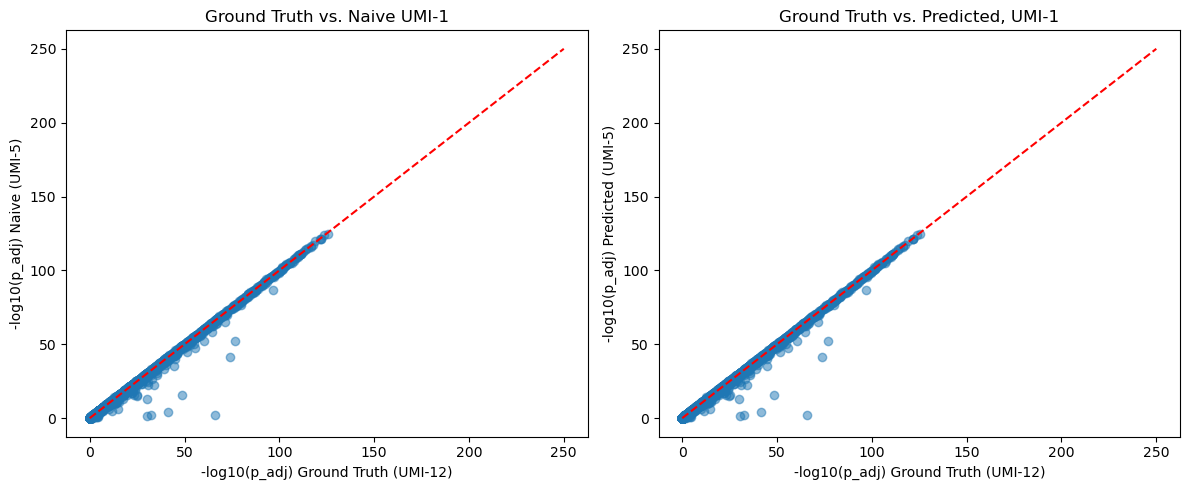

In [297]:
# === Step 3: Merge p-values by gene name for plotting ===
merged = de_12[['names', 'pvals_adj']].merge(
    de_naive[['names', 'pvals_adj']], on='names', suffixes=('_12', '_5')
).merge(
    de_pred[['names', 'pvals_adj']], on='names'
).rename(columns={'pvals_adj': 'pvals_adj_pred'})

# === Step 4: Plotting ===
plt.figure(figsize=(12, 5))

# Ground truth vs. naive
plt.subplot(1, 2, 1)
plt.scatter(-np.log10(merged['pvals_adj_12'] + 1e-300), -np.log10(merged['pvals_adj_5'] + 1e-300), alpha=0.5)
plt.plot([0, 250], [0, 250], color='red', linestyle='--', label='y=x')
plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
plt.ylabel('-log10(p_adj) Naive (UMI-5)')
plt.title(f'Ground Truth vs. Naive UMI-{j}')
# Ground truth vs. predicted
plt.subplot(1, 2, 2)
plt.scatter(-np.log10(merged['pvals_adj_12'] + 1e-300), -np.log10(merged['pvals_adj_pred'] + 1e-300), alpha=0.5)
plt.plot([0, 250], [0, 250], color='red', linestyle='--', label='y=x')
plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
plt.ylabel('-log10(p_adj) Predicted (UMI-5)')
## I want to plot the y = x line 

plt.title(f'Ground Truth vs. Predicted, UMI-{j}')

plt.tight_layout()
plt.show()

In [298]:
print("Using X:", adata_12.X[cd14_cells, idx].mean(), adata_12.X[other_cells, idx].mean())
print("Using raw.X:", adata_12.raw.X[cd14_cells, idx].mean(), adata_12.raw.X[other_cells, idx].mean())


NameError: name 'cd14_cells' is not defined

In [246]:
mu1 = np.expm1(4).mean()
mu2 = np.expm1(0).mean()
lfc = np.log2((mu1+1e-9)/(mu2+1e-9))
print(f"Log Fold Change (LFC) for {gene}: {lfc:.4f}")

Log Fold Change (LFC) for FCN1: 35.6415


In [247]:
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
# adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")
# adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5

# labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
# reference_labels = labels.obs['majority_voting'].copy()

# # Convert annotations: CD14_mono → CD14_mono, all others → Other cells
# binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
# adata_12.obs['label'] = binary_labels

# adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
# adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]

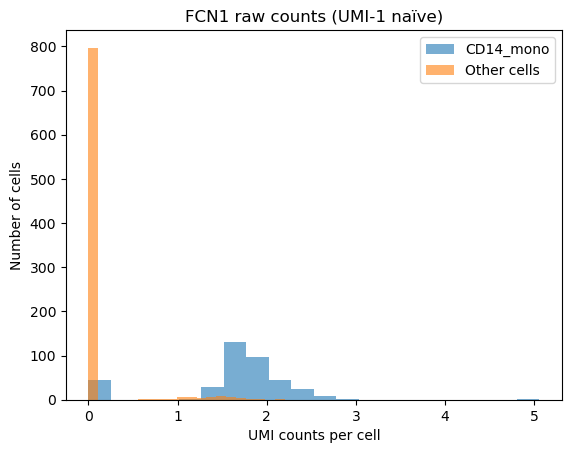

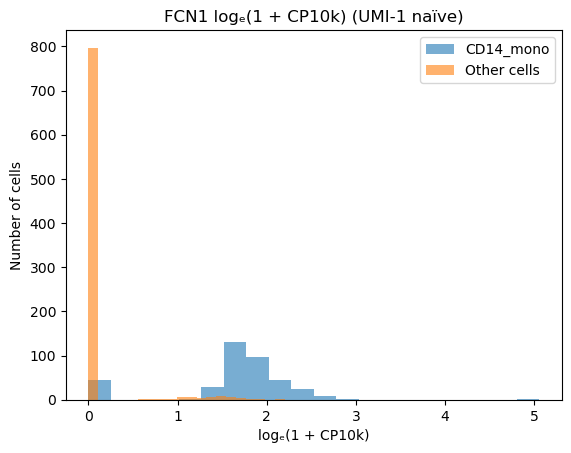

In [248]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

gene = "FCN1"
g_idx = adata_naive.var_names.get_loc(gene)
is_cd14 = adata_naive.obs["label"] == "CD14_mono"

# --- raw counts
raw_counts = adata_naive.raw.X[:, g_idx].ravel()
plt.figure()
plt.hist(raw_counts[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
plt.hist(raw_counts[~is_cd14], bins=20, alpha=0.6, label="Other cells")
plt.title("FCN1 raw counts (UMI-1 naïve)")
plt.xlabel("UMI counts per cell"); plt.ylabel("Number of cells"); plt.legend(); plt.show()

# --- log-transformed counts
log_counts = adata_naive.X[:, g_idx].ravel()
plt.figure()
plt.hist(log_counts[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
plt.hist(log_counts[~is_cd14], bins=20, alpha=0.6, label="Other cells")
plt.title("FCN1 logₑ(1 + CP10k) (UMI-1 naïve)")
plt.xlabel("logₑ(1 + CP10k)"); plt.ylabel("Number of cells"); plt.legend(); plt.show()


## Load and Align the three AnnData Objects

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data3
j =3
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5

# adata_pred.X = np.round (adata_pred.X).astype(int)  # Convert predicted counts to integer

print(adata_naive.X)
print(adata_pred.X)
print("================")
print(np.linalg.norm(adata_12.X - adata_naive.X, ord='fro'))

print(np.linalg.norm(adata_12.X - adata_pred.X, ord='fro'))

print (np.linalg.norm(adata_naive.X - adata_pred.X, ord='fro'))

[[0. 0. 0. ... 2. 3. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 1. 8. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
[[0.         0.         0.         ... 2.0175654  3.05327192 1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         3.05327192 ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         3.05327192]
 [0.         0.         0.         ... 1.         8.52494637 0.        ]
 [0.         0.         0.         ... 2.0175654  0.         0.        ]]
32547.081220902128
28148.893637643392
13250.040845426762


In [4]:
# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
print(binary_labels)
# Assign binary labels to the datasets


barcode
AAACCCAAGGAGAGTA-1      CD14_mono
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1      CD14_mono
TTTGTTGCAATTAGGA-1    Other cells
Name: majority_voting, Length: 1232, dtype: object


# CURRENT Pipeline 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [20]:
# Load data31
j = 1
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5


assert adata_12.obs_names.equals(adata_naive.obs_names), "Cell barcodes differ!"
assert adata_12.var_names.equals(adata_naive.var_names), "Genes differ!"


# adata_pred.X = np.round (adata_pred.X).astype(int)  # Convert predicted counts to integer

print(adata_naive.X)
print(adata_pred.X)
print("================")
print(np.linalg.norm(adata_12.X - adata_naive.X, ord='fro'))

print(np.linalg.norm(adata_12.X - adata_pred.X, ord='fro'))

print (np.linalg.norm(adata_naive.X - adata_pred.X, ord='fro'))

[[0. 0. 0. ... 2. 3. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 1. 3. 0.]
 [0. 0. 0. ... 2. 0. 0.]]
[[0.         0.         0.         ... 2.46388217 4.927138   1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.46388217 ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         2.46388217]
 [0.         0.         0.         ... 1.         4.927138   0.        ]
 [0.         0.         0.         ... 2.46388217 0.         0.        ]]
36695.976659574
36039.81842339125
2834.9126382072127


### Step 1: Load Labels and Preprocess Datasets 

In [21]:

# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
print(binary_labels)
# Assign binary labels to the datasets

barcode
AAACCCAAGGAGAGTA-1      CD14_mono
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1      CD14_mono
TTTGTTGCAATTAGGA-1    Other cells
Name: majority_voting, Length: 1232, dtype: object


In [22]:
# BEFORE normalisation

### X-axis average counts and y-axis accuracy metric
    
adata_12.raw  = adata_12.copy()
adata_naive.raw = adata_naive.copy()
adata_pred.raw  = adata_pred.copy()

# sc.pp.highly_variable_genes(adata_12, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)

# Repeat for naive and pred
# sc.pp.highly_variable_genes(adata_naive, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

# sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_pred, target_sum=1e4) 
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)

    
    
# print("This is the matrix for adata_12", adata_12.X)
# print("This is the matrix for adata_naive", adata_naive.X)
# print("This is the matrix for adata_pred", adata_pred.X)



This is the matrix for adata_12 [[0.         0.         0.         ... 0.91707144 1.17955576 0.5601735 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.68582339 ... 0.90244774 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.82676689]
 [0.         0.         0.         ... 0.50130374 1.82567404 0.        ]
 [0.         0.         0.         ... 1.30317499 0.         0.        ]]
This is the matrix for adata_naive [[0.         0.         0.         ... 1.34371627 1.65820784 0.88237453]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.75858657 ... 1.22439696 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.73339425]
 [0.         0.         0.         ... 0.83433038 1.59123598 0.        ]
 [0.         0.         0.         ... 1.75323859 0.         0.        ]]
This is the matrix for adata_pred [[0.       

### Step 3: Run DE using t-test

- The following command compares gene expression between one cluster and all other clusters, across all genes, to find the most distinctly expressed genes

- For each gene and each cluster, scanpy computes log fold change, p-value, adj p-value, scores for ranking genes \n

- Tell you which genes are significanty more (or less) expressed in one cluster compared to the others

In [23]:
method = 'wilcoxon'  # Using t-test for differential expression analysis
sc.tl.rank_genes_groups(
    adata_12,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_naive,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_pred,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)

### Step 4: Extract DE results for one cluster

- extracting differential gene expression results for  specific cluster after running rank_gene_groups 
- The function below returns a pandas dataframe containing the ranked list of differentially expressed genes from a specific group clsuter
- group 1: You're pulling the DE genes where cluster "1" is compared against all the other clusters (one vs. rest)
- key = "t-test": You'res saying, "Give me the results from the DE analysis that used the t-test method
- de_12 = DE genes for cluster 1 using ground truth UMI-12 counts 
- de_5 = DE genes for cluster 1 using naive UMI-5 counts 
- de_5_pred: DE genes for cluster 1 usig predicited UMI-5 counts 

In [14]:
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth

# import pandas as pd
# import numpy as np
# import scipy.sparse as sp

# X = adata_12.X
# avg_counts = (np.asarray(X.mean(axis=0)).ravel()
#               if sp.issparse(X) else X.mean(axis=0))

# df_avg = pd.DataFrame({
#     "gene": adata_12.var_names,
#     "avg_count": avg_counts
# })


# gene = "S100A9"
# avg = df_avg.loc[df_avg["gene"] == gene, "avg_count"].iloc[0]
# print(f"Average count for {gene}: {avg:.3f}")



In [24]:
de_12 = sc.get.rank_genes_groups_df(adata_12, group='CD14_mono', key=method)
de_naive = sc.get.rank_genes_groups_df(adata_naive, group='CD14_mono', key=method)
de_pred = sc.get.rank_genes_groups_df(adata_pred, group='CD14_mono', key=method)
print(de_12.head(10))
print("==================================")
print(de_naive.head(10))
print("==================================")
print(de_pred.head(10))
assert(len(de_12)) == len(de_naive) == len(de_pred), "Number of DE genes differ across datasets!"

    names     scores  logfoldchanges          pvals      pvals_adj
0  S100A8  24.376497        8.126340  3.036706e-131  8.571408e-127
1    FCN1  24.240925        6.652136  8.242455e-130  1.163258e-125
2    VCAN  24.172318        7.201283  4.350602e-129  4.093336e-125
3   CSF3R  24.151094        6.242465  7.271675e-129  5.131257e-125
4  S100A9  24.072783        7.948786  4.820402e-128  2.721213e-124
5     LYZ  23.927076        7.358271  1.601073e-126  7.531983e-123
6    MNDA  23.739271        6.015524  1.418197e-124  5.003754e-121
7  PLXDC2  23.455481        5.357612  1.162175e-121  2.982140e-118
8   LRMDA  23.421003        5.643537  2.611302e-121  6.142218e-118
9    CD36  23.336889        5.702466  1.872656e-120  4.065969e-117
     names     scores  logfoldchanges          pvals      pvals_adj
0     FCN1  24.173183        5.541690  4.260295e-129  1.202511e-124
1    CSF3R  24.085604        5.766765  3.538183e-128  4.993438e-124
2     VCAN  24.058489        5.625188  6.803446e-128  6.401

In [25]:
import pandas as pd
import numpy as np
import scipy.sparse as sp


adata_gt = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
# 1) Compute average counts per gene from adata_12
X12 = adata_gt.X
if sp.issparse(X12):
    avg12 = np.asarray(X12.mean(axis=0)).ravel()
else:
    avg12 = X12.mean(axis=0)

df_avg12 = pd.DataFrame({
    "gene": adata_gt.var_names,
    "avg_count": avg12
})

# 2) Merge into new DE DataFrames (preserving original de_* unmodified)
de_12_avg    = de_12   .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")

# 3) Inspect
print("Ground truth DE + avg:\n",    de_12_avg   .head(), "\n")
print("Naive DE + avg:\n",           de_naive_avg.head(), "\n")
print("Predicted DE + avg:\n",       de_pred_avg .head(), "\n")
print(len(de_12_avg), len(de_naive_avg), len(de_pred_avg))


Ground truth DE + avg:
     names     scores  logfoldchanges          pvals      pvals_adj  avg_count
0  S100A8  24.376497        8.126340  3.036706e-131  8.571408e-127  38.176948
1    FCN1  24.240925        6.652136  8.242455e-130  1.163258e-125   6.495942
2    VCAN  24.172318        7.201283  4.350602e-129  4.093336e-125  10.063312
3   CSF3R  24.151094        6.242465  7.271675e-129  5.131257e-125   2.388799
4  S100A9  24.072783        7.948786  4.820402e-128  2.721213e-124  55.384740 

Naive DE + avg:
     names     scores  logfoldchanges          pvals      pvals_adj  avg_count
0    FCN1  24.173183        5.541690  4.260295e-129  1.202511e-124   6.495942
1   CSF3R  24.085604        5.766765  3.538183e-128  4.993438e-124   2.388799
2    VCAN  24.058489        5.625188  6.803446e-128  6.401135e-124  10.063312
3  S100A8  23.964327        4.815764  6.551828e-127  4.623297e-123  38.176948
4    MNDA  23.795057        5.268267  3.757371e-125  2.121111e-121   4.131494 

Predicted DE + avg:

## Threshold Stuff

#### First 

In [14]:
# Define your thresholds
strict_thresh = 10e-80  # i.e. 1e-19
lax_thresh    = 10e-78   # i.e. 1e-4

# 1) Naïve recovery
# -----------------
# Genes called “significant” under the strict threshold in the naïve DE
strict_naive = set(
    de_naive_avg.loc[de_naive_avg['pvals_adj'] <= strict_thresh, 'names']
)
n_strict_naive = len(strict_naive)

# Genes called under the lax threshold in the ground truth DE
lax_gt = set(
    de_12_avg.loc[de_12_avg['pvals_adj'] <= lax_thresh, 'names']
)

print(f"Ground truth DE genes at p≤{lax_thresh}: {len(lax_gt)}")
# Proportion recovered
recov_naive = len(strict_naive & lax_gt) / n_strict_naive if n_strict_naive > 0 else np.nan

print(f"Naïve: {n_strict_naive} genes at p≤{strict_thresh}, "
      f"{len(strict_naive & lax_gt)} recovered at p≤{lax_thresh} in truth "
      f"({recov_naive:.3%})")

# 2) Predicted recovery
# ----------------------
strict_pred = set(
    de_pred_avg.loc[de_pred_avg['pvals_adj'] <= strict_thresh, 'names']
)
n_strict_pred = len(strict_pred)

recov_pred = len(strict_pred & lax_gt) / n_strict_pred if n_strict_pred > 0 else np.nan

print(f"Predicted: {n_strict_pred} genes at p≤{strict_thresh}, "
      f"{len(strict_pred & lax_gt)} recovered at p≤{lax_thresh} in truth "
      f"({recov_pred:.3%})")





Ground truth DE genes at p≤1e-77: 197
Naïve: 190 genes at p≤1e-79, 190 recovered at p≤1e-77 in truth (100.000%)
Predicted: 189 genes at p≤1e-79, 189 recovered at p≤1e-77 in truth (100.000%)


In [15]:
# Define the same thresholds
strict_thresh = 10e-50 # i.e. 1e-19
lax_thresh    = 10e-45   # i.e. 1e-4

# 1) Strict on ground truth, lax on naïve
strict_gt = set(
    de_12_avg.loc[de_12_avg['pvals_adj'] <= strict_thresh, 'names']
)
n_strict_gt = len(strict_gt)
print(f"Ground truth strict: {n_strict_gt} genes at p≤{strict_thresh}")

lax_naive = set(
    de_naive_avg.loc[de_naive_avg['pvals_adj'] <= lax_thresh, 'names']
)
print(len(lax_naive), "genes at p≤", lax_thresh, "in naive")

recov_naive_rev = len(strict_gt & lax_naive) / n_strict_gt if n_strict_gt > 0 else np.nan

print(f"Ground truth strict: {n_strict_gt} genes at p≤{strict_thresh}, "
      f"{len(strict_gt & lax_naive)} recovered at p≤{lax_thresh} in naive "
      f"({recov_naive_rev:.3%})")

# 2) Strict on ground truth, lax on predicted
lax_pred = set(
    de_pred_avg.loc[de_pred_avg['pvals_adj'] <= lax_thresh, 'names']
)

recov_pred_rev = len(strict_gt & lax_pred) / n_strict_gt if n_strict_gt > 0 else np.nan

print(f"Ground truth strict: {n_strict_gt} genes at p≤{strict_thresh}, "
      f"{len(strict_gt & lax_pred)} recovered at p≤{lax_thresh} in predicted "
      f"({recov_pred_rev:.3%})")


Ground truth strict: 465 genes at p≤1e-49
552 genes at p≤ 1e-44 in naive
Ground truth strict: 465 genes at p≤1e-49, 465 recovered at p≤1e-44 in naive (100.000%)
Ground truth strict: 465 genes at p≤1e-49, 465 recovered at p≤1e-44 in predicted (100.000%)


In [16]:

# ### Adata naive

# import scanpy as sc
# import numpy as np
# import matplotlib.pyplot as plt

# gene = "FCN1"
# g_idx = adata_naive.var_names.get_loc(gene)
# is_cd14 = adata_naive.obs["label"] == "CD14_mono"

# # --- raw counts
# raw_counts = adata_naive.raw.X[:, g_idx].ravel()
# plt.figure()
# plt.hist(raw_counts[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
# plt.hist(raw_counts[~is_cd14], bins=20, alpha=0.6, label="Other cells")
# plt.title("FCN1 raw counts (UMI-1 naïve)")
# plt.xlabel("UMI counts per cell"); plt.ylabel("Number of cells"); plt.legend(); plt.show()

# # --- log-transformed counts
# log_counts = adata_naive.X[:, g_idx].ravel()
# plt.figure()
# plt.hist(log_counts[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
# plt.hist(log_counts[~is_cd14], bins=20, alpha=0.6, label="Other cells")
# plt.title("FCN1 logₑ(1 + CP10k) (UMI-1 naïve)")
# plt.xlabel("logₑ(1 + CP10k)"); plt.ylabel("Number of cells"); plt.legend(); plt.show()


barcode
AAACCCAAGGAGAGTA-1      CD14_mono
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1      CD14_mono
TTTGTTGCAATTAGGA-1    Other cells
Name: majority_voting, Length: 1232, dtype: object


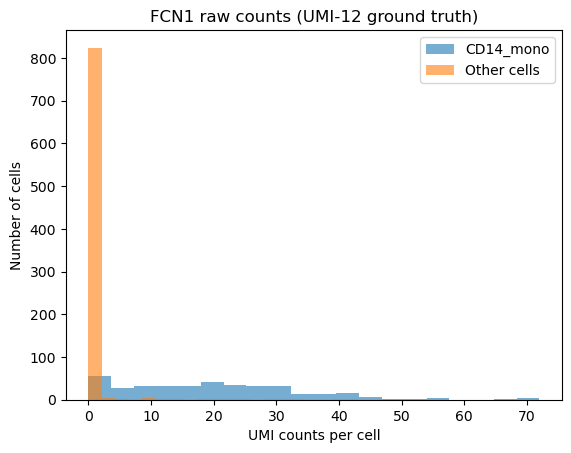

<Figure size 640x480 with 0 Axes>

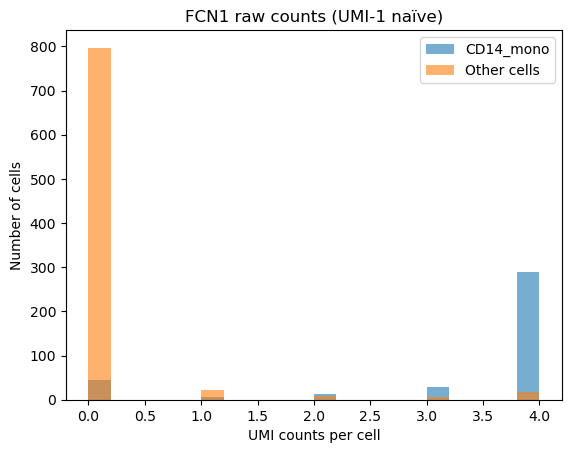

<Figure size 640x480 with 0 Axes>

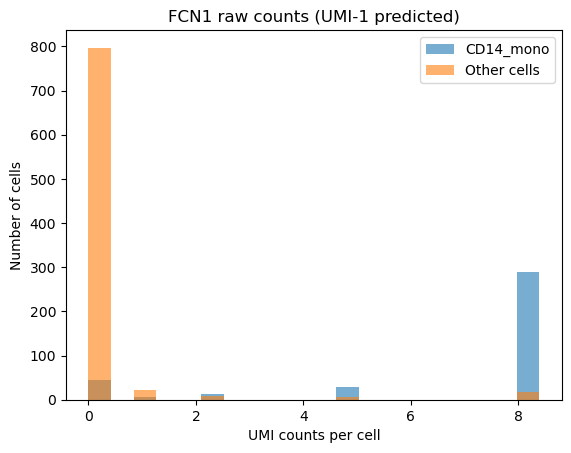

<Figure size 640x480 with 0 Axes>

In [28]:

### Adata 12

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
j = 1

# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')
print(binary_labels)
# Assign binary labels to the datasets

adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5
adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = adata_12.obs["label"] == "CD14_mono"

# --- raw counts ground truth
raw_counts1 = adata_12.X[:, g_idx].ravel()
plt.figure()
plt.hist(raw_counts1[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
plt.hist(raw_counts1[~is_cd14], bins=20, alpha=0.6, label="Other cells")
plt.title("FCN1 raw counts (UMI-12 ground truth)")
plt.xlabel("UMI counts per cell"); plt.ylabel("Number of cells"); plt.legend(); plt.show()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_gt_UMI_{j}.pdf")

# --- raw counts ground naive 
raw_counts2 = adata_naive.X[:, g_idx].ravel()
plt.figure()
plt.hist(raw_counts2[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
plt.hist(raw_counts2[~is_cd14], bins=20, alpha=0.6, label="Other cells")
plt.title("FCN1 raw counts (UMI-1 naïve)")
plt.xlabel("UMI counts per cell"); plt.ylabel("Number of cells"); plt.legend(); plt.show()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_pred_UMI_{j}.pdf")

raw_counts3 = adata_pred.X[:, g_idx].ravel()
plt.figure()
plt.hist(raw_counts3[is_cd14], bins=20, alpha=0.6, label="CD14_mono")
plt.hist(raw_counts3[~is_cd14], bins=20, alpha=0.6, label="Other cells")
plt.title("FCN1 raw counts (UMI-1 predicted)")
plt.xlabel("UMI counts per cell"); plt.ylabel("Number of cells"); plt.legend(); plt.show()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_naive_UMI_{j}.pdf")



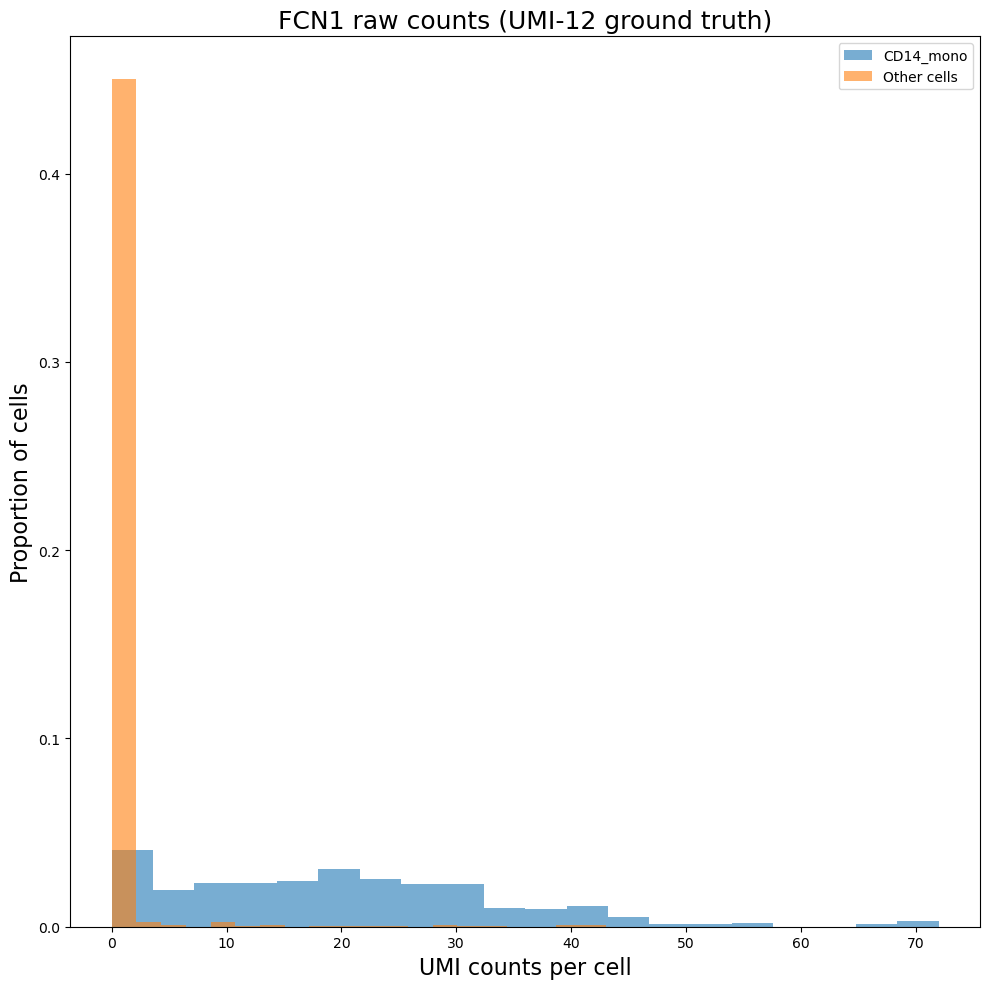

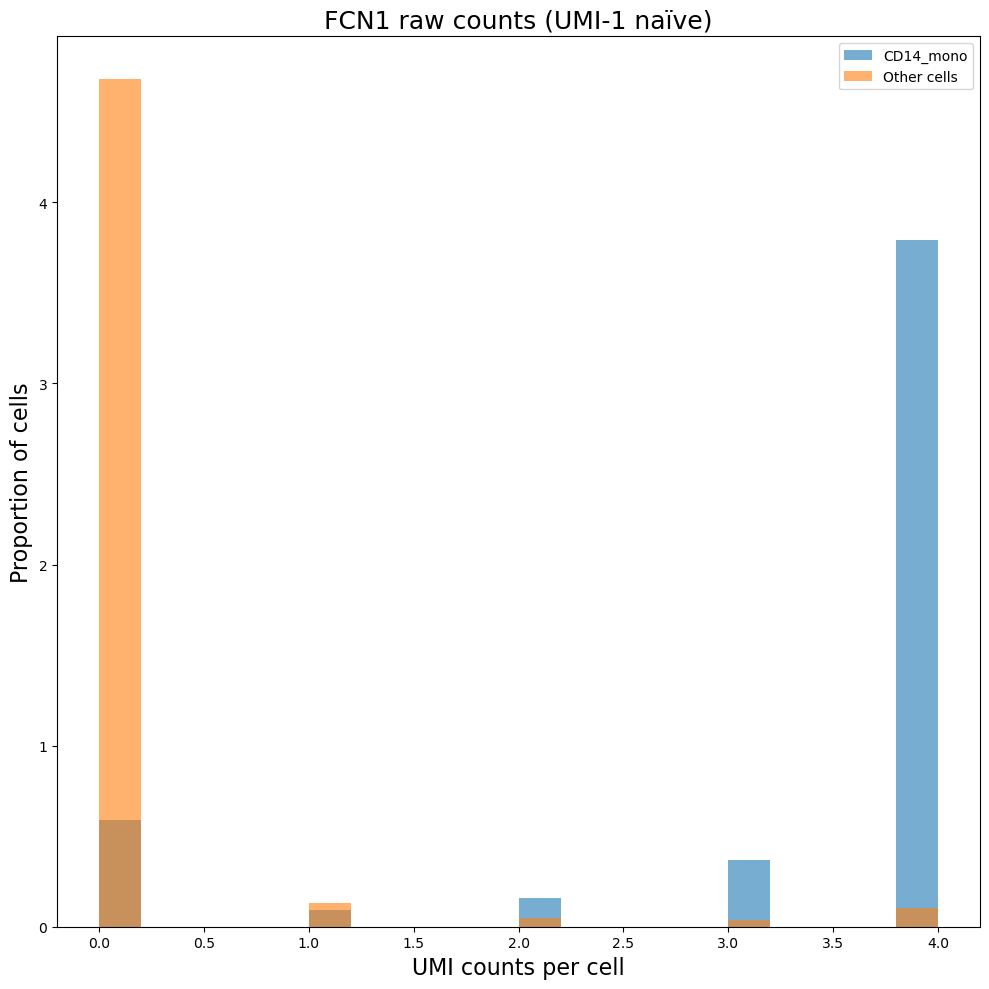

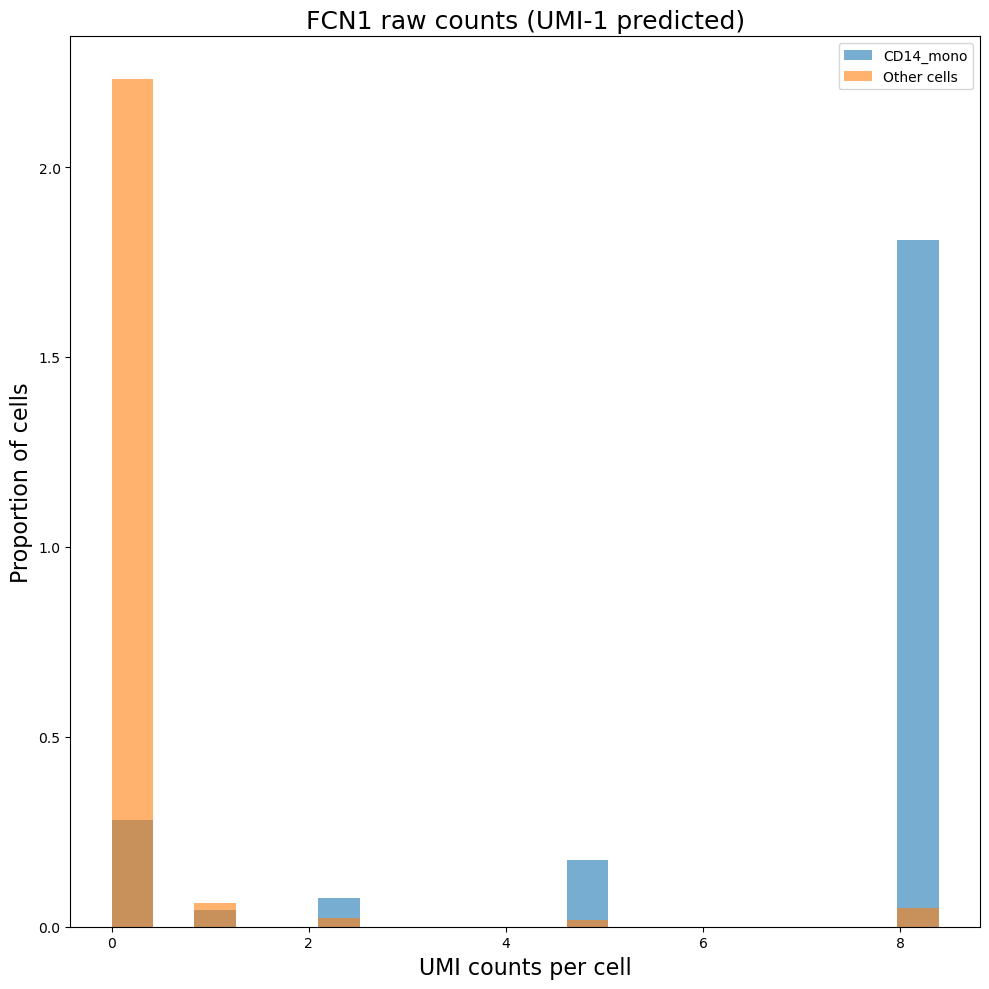

In [31]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

j = 1

# Load cell annotation labels
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations to binary labels
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   
adata_pred  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = adata_12.obs["label"] == "CD14_mono"

# --- raw counts ground truth (proportions)
raw_counts1 = adata_12.X[:, g_idx].ravel()
plt.figure(figsize=(10,10))
plt.hist(raw_counts1[is_cd14], bins=20, alpha=0.6, label="CD14_mono", density=True)
plt.hist(raw_counts1[~is_cd14], bins=20, alpha=0.6, label="Other cells", density=True)
plt.title("FCN1 raw counts (UMI-12 ground truth)",fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16); plt.ylabel("Proportion of cells", fontsize =16); plt.legend()
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_gt_UMI_{j}.pdf")
plt.show()


# --- raw counts naive (proportions)
raw_counts2 = adata_naive.X[:, g_idx].ravel()
plt.figure(figsize=(10,10))
plt.hist(raw_counts2[is_cd14], bins=20, alpha=0.6, label="CD14_mono", density=True)
plt.hist(raw_counts2[~is_cd14], bins=20, alpha=0.6, label="Other cells", density=True)
plt.title(f"FCN1 raw counts (UMI-{j} naïve)", fontsize = 18)
plt.xlabel("UMI counts per cell", fontsize =16); plt.ylabel("Proportion of cells", fontsize = 16); plt.legend()
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_naive_UMI_{j}.pdf")
plt.show()




# --- raw counts predicted (proportions)
raw_counts3 = adata_pred.X[:, g_idx].ravel()
plt.figure(figsize=(10,10))
plt.hist(raw_counts3[is_cd14], bins=20, alpha=0.6, label="CD14_mono", density=True)
plt.hist(raw_counts3[~is_cd14], bins=20, alpha=0.6, label="Other cells", density=True)
plt.title(f"FCN1 raw counts (UMI-{j} predicted)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16); plt.ylabel("Proportion of cells", fontsize =16); plt.legend()
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_pred_UMI_{j}.pdf")
plt.show()




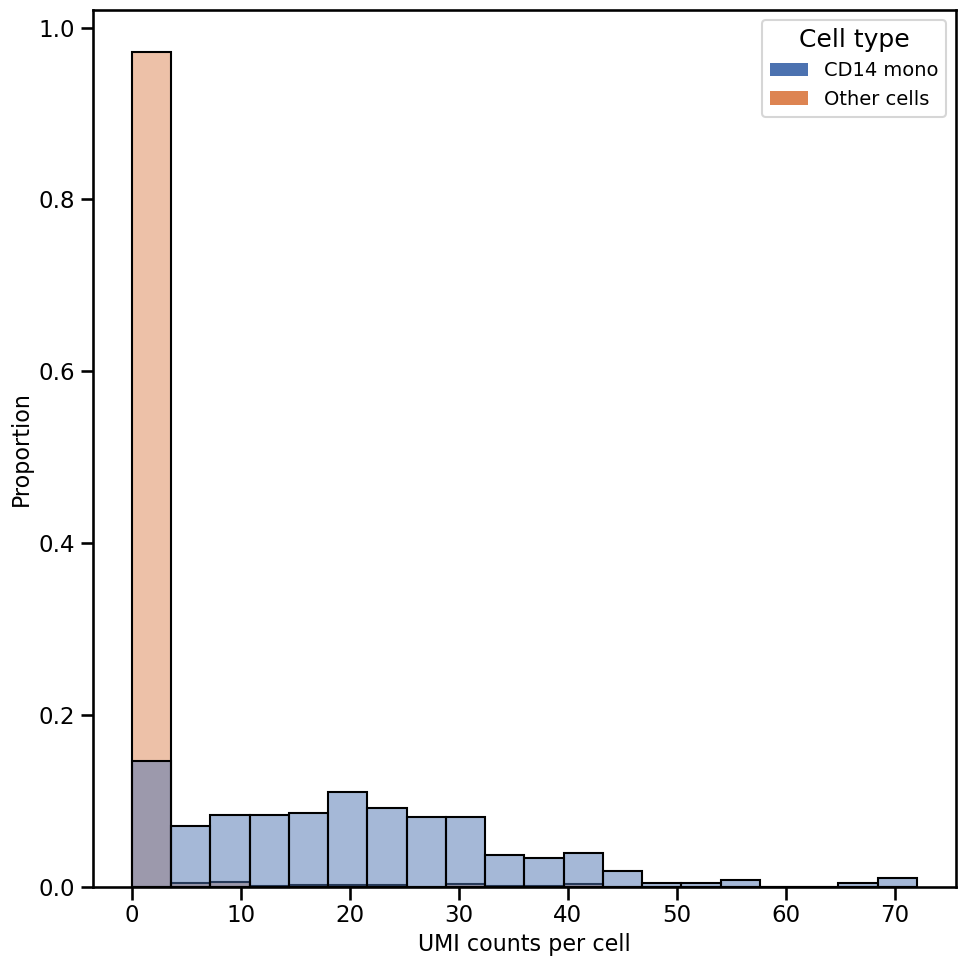

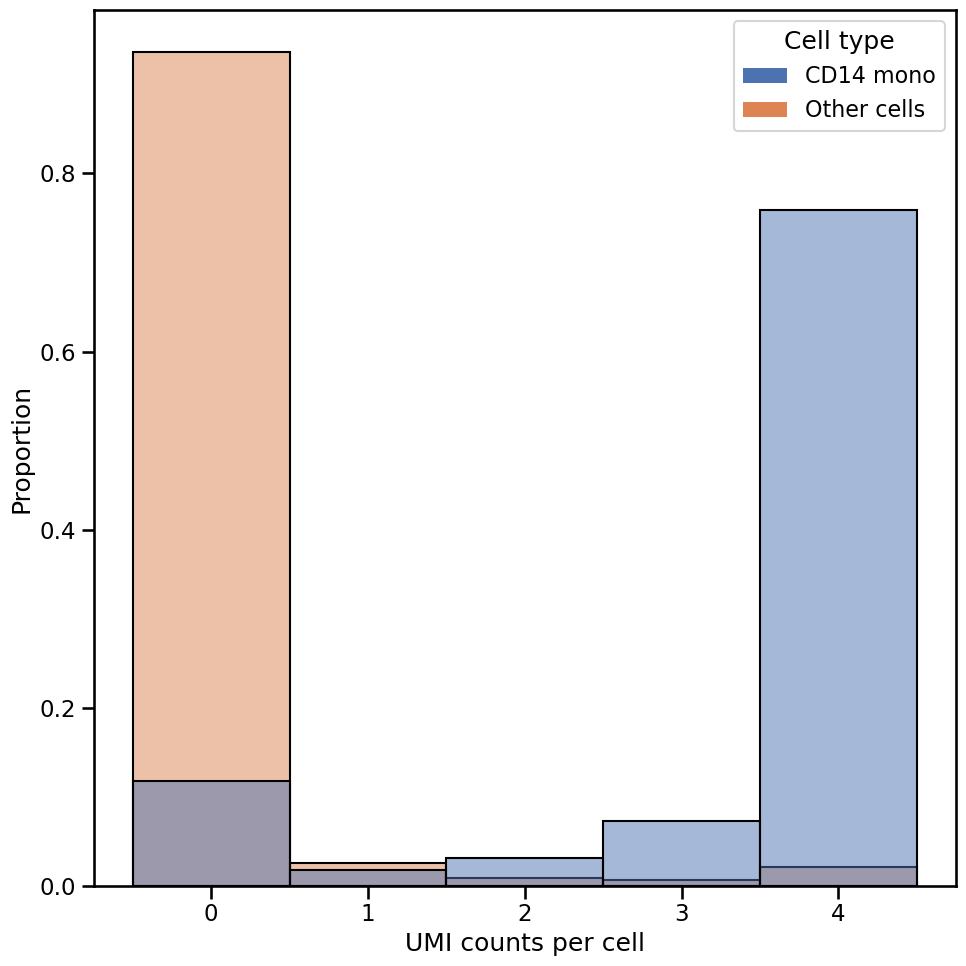

In [21]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

sns.set_context("talk")

j = 1  # naive UMI length

# Load cell annotation labels
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = (adata_12.obs["label"] == "CD14_mono").values  # boolean array aligned to obs

def dense_col(X, idx):
    col = X[:, idx]
    return col.toarray().ravel() if not isinstance(col, np.ndarray) else col.ravel()

# Use a fixed palette so our manual legend colors match the bars
_palette = sns.color_palette("deep", n_colors=2)
palette_map = {"CD14_mono": _palette[0], "Other cells": _palette[1]}

# -------- Panel A: Ground truth UMI-12 (PMF, shared bins) --------
vals_gt = dense_col(adata_12.X, g_idx)
vals_gt_cd14  = vals_gt[is_cd14]
vals_gt_other = vals_gt[~is_cd14]

# Shared bins computed from combined data
edges_A = np.histogram_bin_edges(np.concatenate([vals_gt_cd14, vals_gt_other]), bins=20)

dfA = pd.DataFrame({
    "counts": np.concatenate([vals_gt_cd14, vals_gt_other]),
    "group":  (["CD14_mono"] * len(vals_gt_cd14)) + (["Other cells"] * len(vals_gt_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfA, x="counts", hue="group",
    bins=edges_A, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Proportion", fontsize=16)

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, title="Cell type", fontsize=14)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/{gene}_gt_UMI_12_pmf.pdf")
plt.show()

# -------- Panel B: Naive UMI-1 (integer bins, integer ticks) --------
vals_nv = dense_col(adata_naive.X, g_idx)
vals_nv_cd14  = vals_nv[is_cd14]
vals_nv_other = vals_nv[~is_cd14]

# Integer-centered bins: [-0.5, 0.5], [0.5, 1.5], etc.
max_val = int(np.max(np.concatenate([vals_nv_cd14, vals_nv_other])))
edges_B = np.arange(-0.5, max_val + 1.5, 1)

dfB = pd.DataFrame({
    "counts": np.concatenate([vals_nv_cd14, vals_nv_other]),
    "group":  (["CD14_mono"] * len(vals_nv_cd14)) + (["Other cells"] * len(vals_nv_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfB, x="counts", hue="group",
    bins=edges_B, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=18)
plt.ylabel("Proportion", fontsize=18)
plt.xticks(np.arange(0, max_val + 1, 1))

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, title="Cell type", fontsize=16)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/paper_figures/{gene}__naive_UMI_{j}_pmf.pdf")


In [19]:
# Proportion of CD14_mono cells with count == 0 in ground truth
prop_zero_gt = np.mean(vals_gt_cd14 == 0)

# Proportion of CD14_mono cells with count == 0 in naive
prop_zero_nv = np.mean(vals_nv_cd14 == 0)

print(f"Proportion of CD14_mono cells with 0 counts (GT UMI-12): {prop_zero_gt:.3f}")
print(f"Proportion of CD14_mono cells with 0 counts (Naive UMI-{j}): {prop_zero_nv:.3f}")


Proportion of CD14_mono cells with 0 counts (GT UMI-12): 0.118
Proportion of CD14_mono cells with 0 counts (Naive UMI-1): 0.118


In [20]:
prop_zero_gt = np.mean(vals_gt_other == 0)
prop_zero_nv = np.mean(vals_nv_other == 0)

print(f"Proportion of Other cells with 0 counts (GT UMI-12): {prop_zero_gt:.3f}")
print(f"Proportion of Other cells with 0 counts (Naive UMI-{j}): {prop_zero_nv:.3f}")

Proportion of Other cells with 0 counts (GT UMI-12): 0.937
Proportion of Other cells with 0 counts (Naive UMI-1): 0.937


In [6]:
# Ground truth counts
n_cd14_gt_zero = np.sum(vals_gt_cd14 == 0)
n_cd14_gt_total = len(vals_gt_cd14)
print(f"GT UMI-12: {n_cd14_gt_zero} / {n_cd14_gt_total} CD14_mono cells have count 0 "
      f"({n_cd14_gt_zero / n_cd14_gt_total:.3f})")

# Naive counts
n_cd14_nv_zero = np.sum(vals_nv_cd14 == 0)
n_cd14_nv_total = len(vals_nv_cd14)
print(f"Naive UMI-{j}: {n_cd14_nv_zero} / {n_cd14_nv_total} CD14_mono cells have count 0 "
      f"({n_cd14_nv_zero / n_cd14_nv_total:.3f})")


GT UMI-12: 45 / 381 CD14_mono cells have count 0 (0.118)
Naive UMI-1: 45 / 381 CD14_mono cells have count 0 (0.118)


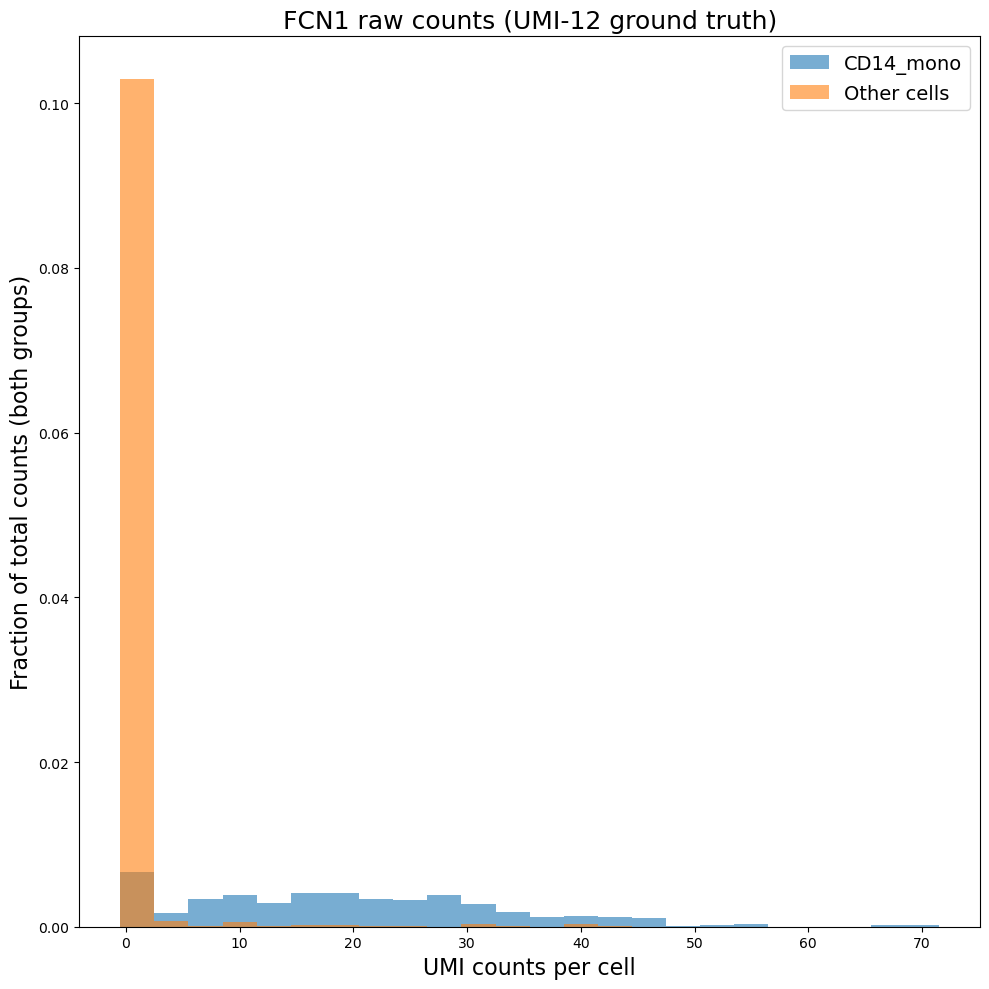

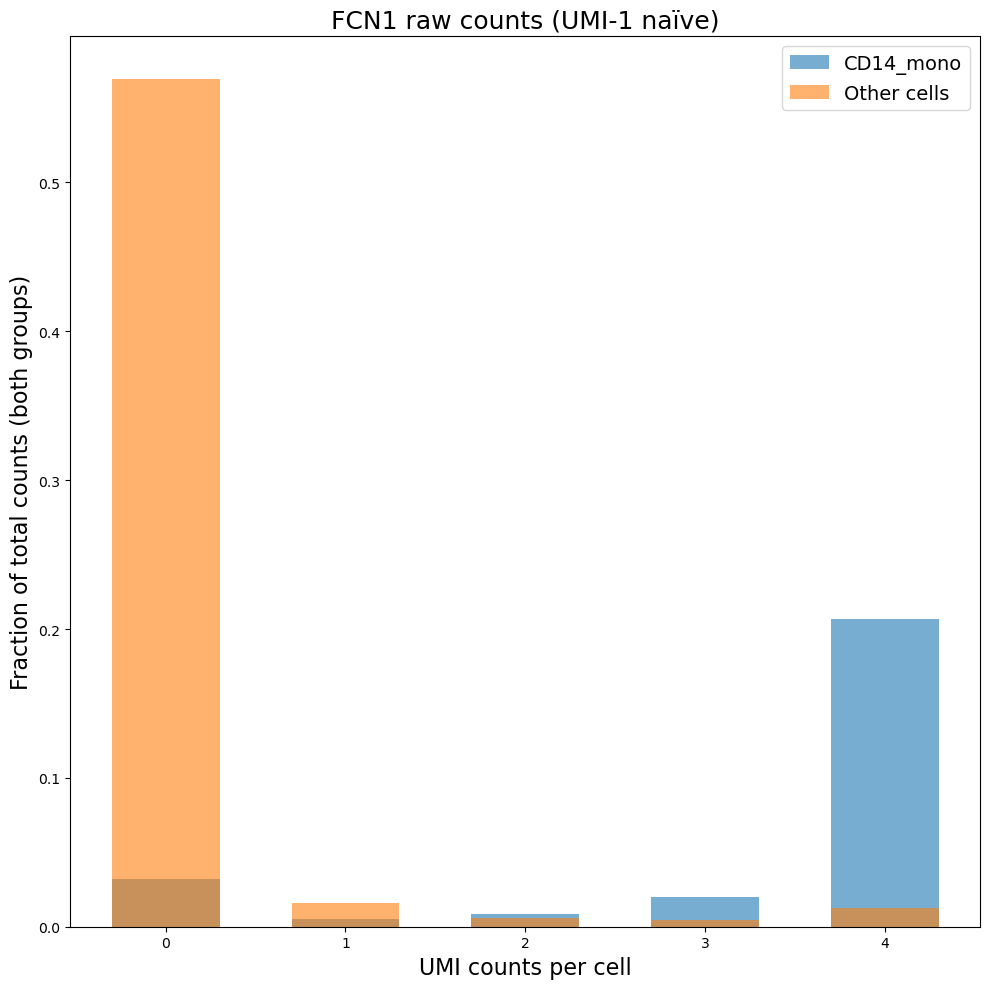

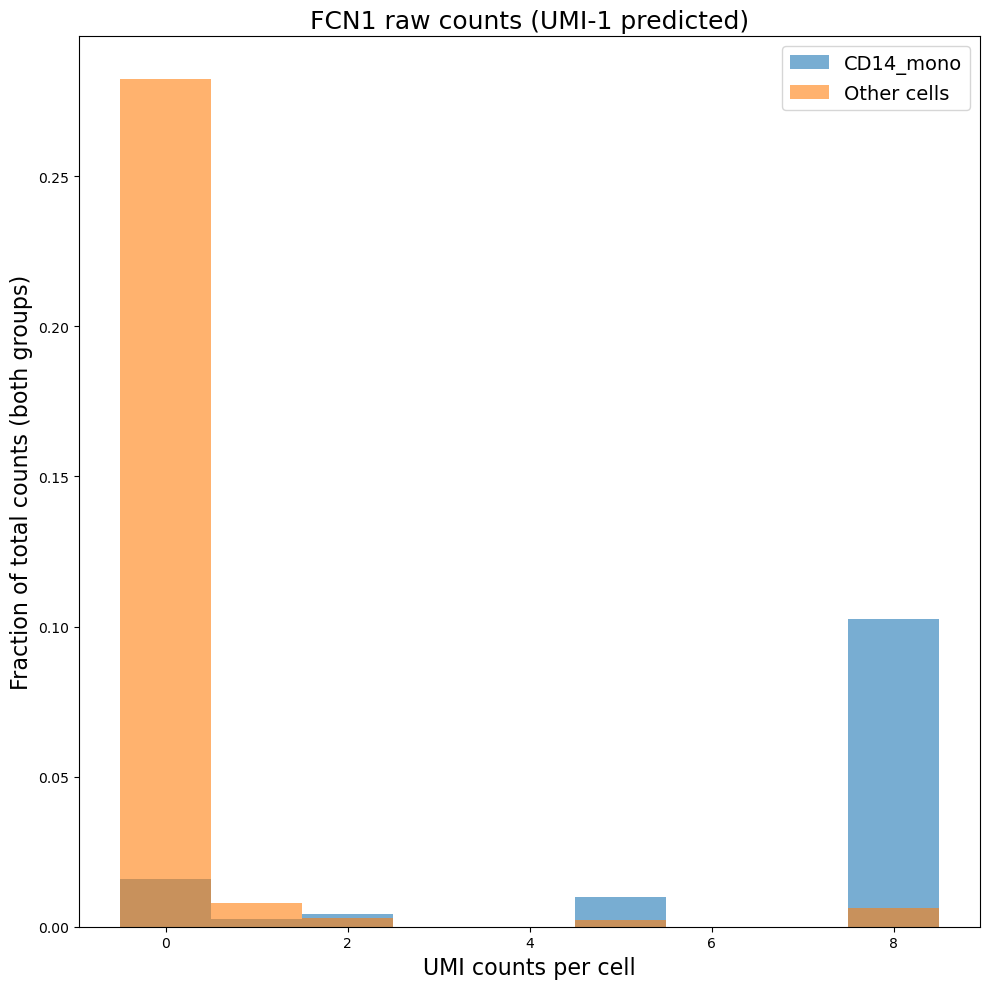

In [30]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

j = 1

# Load cell annotation labels
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()

# Convert annotations to binary labels
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")
adata_pred  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = adata_12.obs["label"] == "CD14_mono"

# ---------- Plot 1: UMI-12 (wider bins) ----------
raw_counts1 = np.asarray(adata_12.X[:, g_idx]).ravel()
cd14_1, other_1 = raw_counts1[is_cd14], raw_counts1[~is_cd14]
total1 = cd14_1.sum() + other_1.sum()
if total1 == 0: total1 = 1.0

# Wider bins: step = 2 (change to 3/5/etc. if you want even wider)
bins1 = np.arange(-0.5, int(raw_counts1.max()) + 1.5, 3)

plt.figure(figsize=(10,10))
plt.hist(cd14_1,  bins=bins1, alpha=0.6, label="CD14_mono",  weights=np.ones_like(cd14_1)/total1)
plt.hist(other_1, bins=bins1, alpha=0.6, label="Other cells", weights=np.ones_like(other_1)/total1)
# plt.title("FCN1 raw counts (UMI-12 ground truth)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Fraction of total counts (both groups)", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_gt_UMI_{j}.pdf")
plt.show()
plt.close()

# ---------- Plot 2: UMI-j naive (adaptive bins, step=1) ----------
raw_counts2 = np.asarray(adata_naive.X[:, g_idx]).ravel()
cd14_2, other_2 = raw_counts2[is_cd14], raw_counts2[~is_cd14]
total2 = cd14_2.sum() + other_2.sum()
if total2 == 0: total2 = 1.0

bins2 = np.arange(-0.5, int(raw_counts2.max()) + 1.5, 1)

plt.figure(figsize=(10,10))
plt.hist(cd14_2,  bins=bins2, alpha=0.6, label="CD14_mono",
         weights=np.ones_like(cd14_2)/total2, rwidth=0.6)  # narrower bars
plt.hist(other_2, bins=bins2, alpha=0.6, label="Other cells",
         weights=np.ones_like(other_2)/total2, rwidth=0.6)
# plt.title(f"FCN1 raw counts (UMI-{j} naïve)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Fraction of total counts (both groups)", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_naive_UMI_{j}.pdf")
plt.show()
plt.close()

# ---------- Plot 3: UMI-j predicted (adaptive bins, step=1) ----------
raw_counts3 = np.asarray(adata_pred.X[:, g_idx]).ravel()
cd14_3, other_3 = raw_counts3[is_cd14], raw_counts3[~is_cd14]
total3 = cd14_3.sum() + other_3.sum()
if total3 == 0: total3 = 1.0

bins3 = np.arange(-0.5, int(raw_counts3.max()) + 1.5, 1)

plt.figure(figsize=(10,10))
plt.hist(cd14_3,  bins=bins3, alpha=0.6, label="CD14_mono",  weights=np.ones_like(cd14_3)/total3)
plt.hist(other_3, bins=bins3, alpha=0.6, label="Other cells", weights=np.ones_like(other_3)/total3)
plt.title(f"FCN1 raw counts (UMI-{j} predicted)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Fraction of total counts (both groups)", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/FCN1_raw_counts_pred_UMI_{j}.pdf")
plt.show()
plt.close()



#### P-value ratios

Sum of absolute log ratios (Naive) U[1]: 1799.8847
Sum of absolute log ratios (Predicted) U[1]: 907.0348


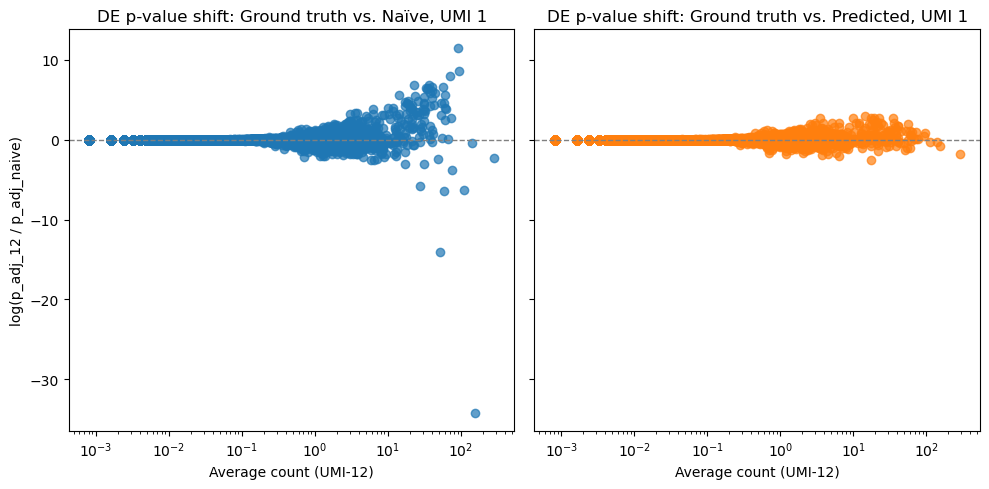

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all three into a single DataFrame
df = (
    de_12_avg[['names','pvals_adj','avg_count']]
      .rename(columns={'pvals_adj':'pval_12'})
      .merge(
          de_naive_avg[['names','pvals_adj']]
            .rename(columns={'pvals_adj':'pval_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','pvals_adj']]
            .rename(columns={'pvals_adj':'pval_pred'}),
          on='names'
      )
)

# 2) Sort by average count
df = df.sort_values('avg_count').reset_index(drop=True)

# 3) Compute log‐ratios
#    Add a tiny pseudocount to avoid log(0)
# eps = 1e-300
df['log_ratio_naive'] = np.log2((df['pval_12'] ) / (df['pval_naive']))
df['log_ratio_pred']  = np.log2((df['pval_12'] ) / (df['pval_pred'] ))


sum_abs_naive = df['log_ratio_naive'].abs().sum()
sum_abs_pred = df['log_ratio_pred'].abs().sum()

print(f"Sum of absolute log ratios (Naive) U[{j}]: {sum_abs_naive:.4f}")
print(f"Sum of absolute log ratios (Predicted) U[{j}]: {sum_abs_pred:.4f}")



# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Subplot 1: ground‐truth vs naive
axes[0].scatter(df['avg_count'], df['log_ratio_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(p_adj_12 / p_adj_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'DE p‐value shift: Ground truth vs. Naïve, UMI {j}')

# Subplot 2: ground‐truth vs predicted
axes[1].scatter(df['avg_count'], df['log_ratio_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'DE p‐value shift: Ground truth vs. Predicted, UMI {j}')

plt.tight_layout()
plt.show()


### Log-fold change values

/data/dagyeman/miniconda3/envs/af/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/dagyeman/miniconda3/envs/af/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Total |log₂(lfc_12/lfc_naive) U[5]| = 1014.994
Total |log₂(lfc_12/lfc_pred) U[5]| = 704.999


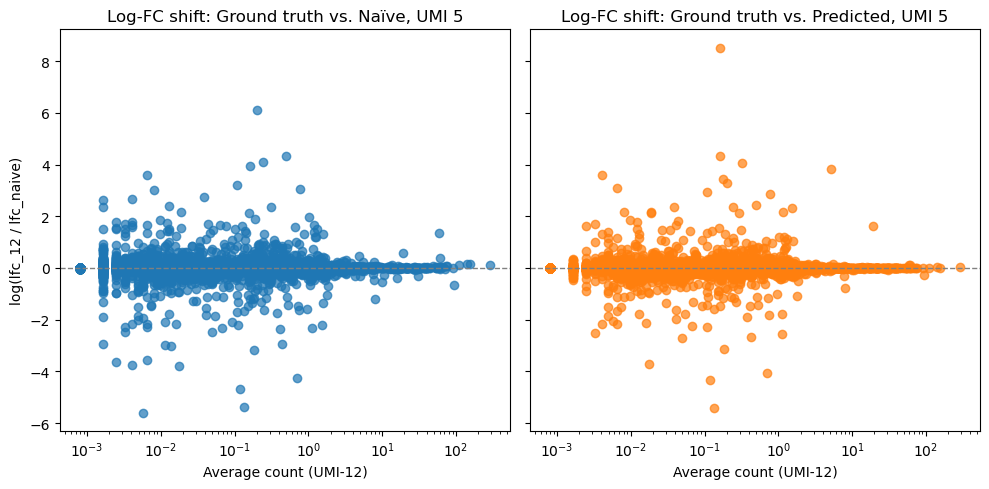

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all three into a single DataFrame using logfoldchanges
df = (
    de_12_avg[['names','logfoldchanges','avg_count']]
      .rename(columns={'logfoldchanges':'lfc_12'})
      .merge(
          de_naive_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_pred'}),
          on='names'
      )
)

# 2) Sort by average count
df = df.sort_values('avg_count').reset_index(drop=True)

# 3) Compute log‐ratio of fold‐changes
eps = 1e-9  # small offset in case any lfc is zero or negative
df['logrf_naive'] = np.log2((df['lfc_12']) / (df['lfc_naive']))
df['logrf_pred']  = np.log2((df['lfc_12'] ) / (df['lfc_pred'] ))

sum_abs_naive = df['logrf_naive'].abs().sum()
sum_abs_pred = df['logrf_pred'].abs().sum()
print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_abs_naive:.3f}")
print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_abs_pred:.3f}")

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Subplot 1: ground‐truth vs naive (fold‐change ratio)
axes[0].scatter(df['avg_count'], df['logrf_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(lfc_12 / lfc_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'Log‐FC shift: Ground truth vs. Naïve, UMI {j}')

# Subplot 2: ground‐truth vs predicted
axes[1].scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'Log‐FC shift: Ground truth vs. Predicted, UMI {j}')

plt.tight_layout()
plt.show()


### Log fold change plot

Total |log₂(lfc_12/lfc_naive) U[5]| = 8.703
Total |log₂(lfc_12/lfc_pred) U[5]| = 3.921


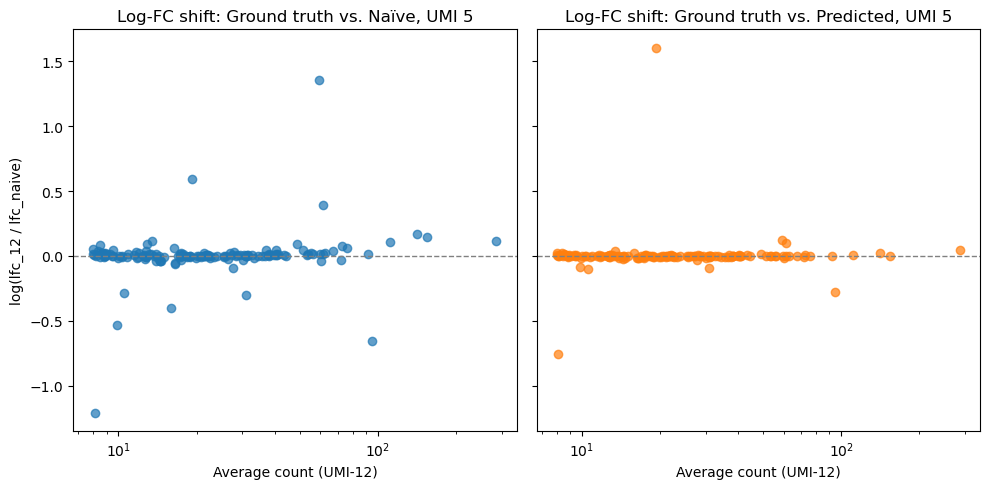

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all three into a single DataFrame using logfoldchanges
df = (
    de_12_avg[['names','logfoldchanges','avg_count']]
      .rename(columns={'logfoldchanges':'lfc_12'})
      .merge(
          de_naive_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','logfoldchanges']]
            .rename(columns={'logfoldchanges':'lfc_pred'}),
          on='names'
      )
)

# --- Filter to genes with avg_count >= 5 in UMI-12 (applies to all via merge) ---
df = df[df['avg_count'] >= 8].reset_index(drop=True)

# 2) Sort by average count
df = df.sort_values('avg_count').reset_index(drop=True)

# 3) Compute log‐ratio of fold‐changes
eps = 1e-9  # small offset in case any lfc is zero or negative (not used below to keep changes minimal)
df['logrf_naive'] = np.log2((df['lfc_12']) / (df['lfc_naive']))
df['logrf_pred']  = np.log2((df['lfc_12']) / (df['lfc_pred'] ))

sum_abs_naive = df['logrf_naive'].abs().sum()
sum_abs_pred = df['logrf_pred'].abs().sum()
print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_abs_naive:.3f}")
print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_abs_pred:.3f}")

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Subplot 1: ground‐truth vs naive (fold‐change ratio)
axes[0].scatter(df['avg_count'], df['logrf_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(lfc_12 / lfc_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'Log‐FC shift: Ground truth vs. Naïve, UMI {j}')

# Subplot 2: ground‐truth vs predicted
axes[1].scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'Log‐FC shift: Ground truth vs. Predicted, UMI {j}')

plt.tight_layout()
plt.show()


### P-value stuff for the paper

Sum of absolute log ratios (Naive) U[5]: 1799.8847
Sum of absolute log ratios (Predicted) U[5]: 907.0348


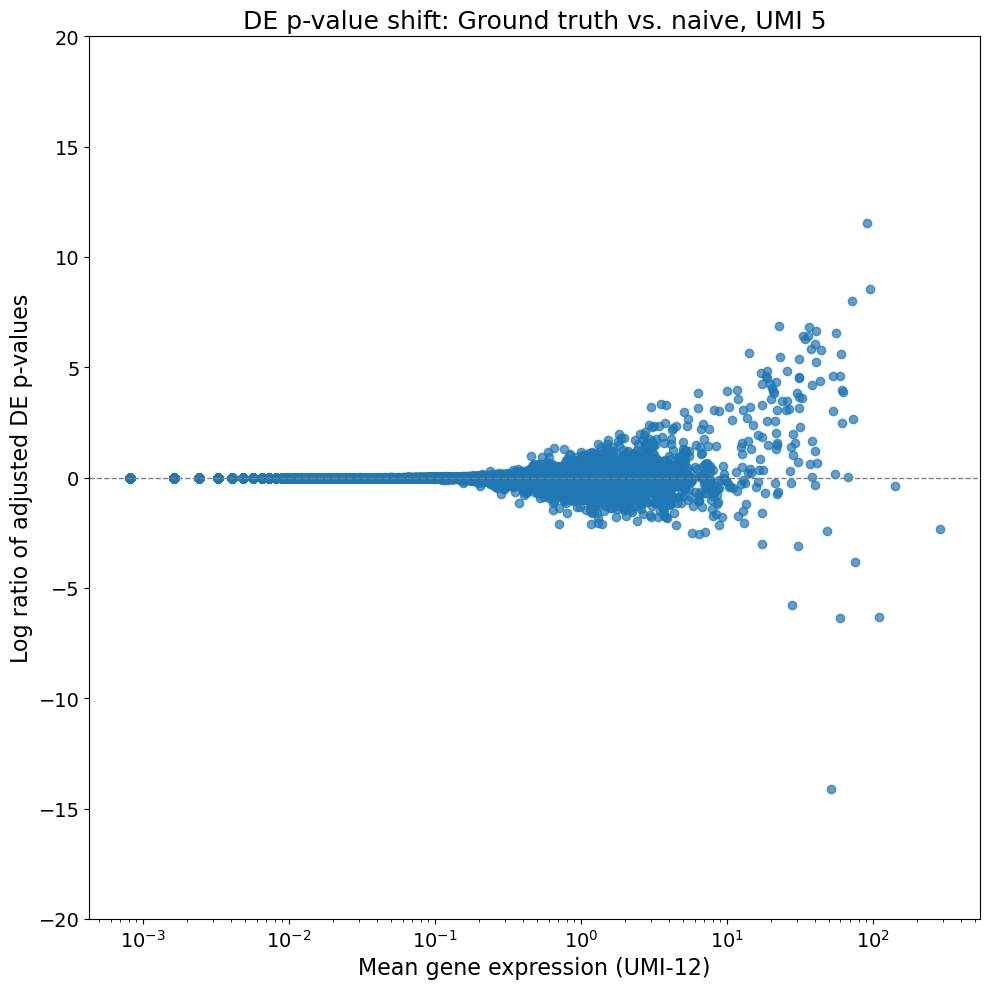

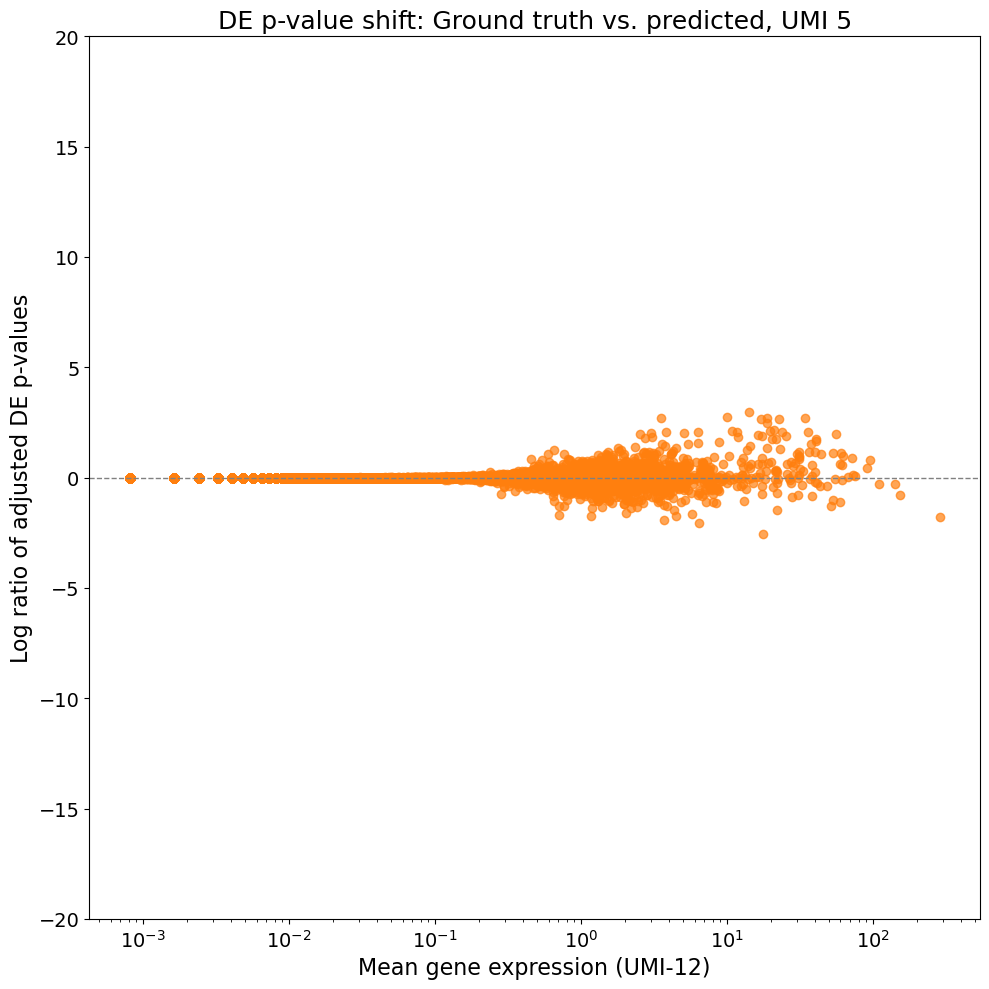

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all three into a single DataFrame
df = (
    de_12_avg[['names','pvals_adj','avg_count']]
      .rename(columns={'pvals_adj':'pval_12'})
      .merge(
          de_naive_avg[['names','pvals_adj']]
            .rename(columns={'pvals_adj':'pval_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names','pvals_adj']]
            .rename(columns={'pvals_adj':'pval_pred'}),
          on='names'
      )
)

# 2) Sort by average count
df = df.sort_values('avg_count').reset_index(drop=True)

# 3) Compute log‐ratios
df['log_ratio_naive'] = np.log2((df['pval_12']) / (df['pval_naive']))
df['log_ratio_pred']  = np.log2((df['pval_12']) / (df['pval_pred'] ))

sum_abs_naive = df['log_ratio_naive'].abs().sum()
sum_abs_pred = df['log_ratio_pred'].abs().sum()

print(f"Sum of absolute log ratios (Naive) U[{j}]: {sum_abs_naive:.4f}")
print(f"Sum of absolute log ratios (Predicted) U[{j}]: {sum_abs_pred:.4f}")

# ===== Figure 1: Ground truth vs Naïve =====
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['log_ratio_naive'], alpha=0.7)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Mean gene expression (UMI-12)', fontsize=16)
plt.ylabel('Log ratio of adjusted DE p-values', fontsize=16)
plt.xscale('log')
plt.title(f'DE p‐value shift: Ground truth vs. naive, UMI {j}', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(-20, 20)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/DE_pval_naive_UMI_{j}.pdf")
plt.show()

# ===== Figure 2: Ground truth vs Predicted =====
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['log_ratio_pred'], alpha=0.7, color='C1')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Mean gene expression (UMI-12)', fontsize=16)
plt.ylabel('Log ratio of adjusted DE p-values', fontsize=16)
plt.xscale('log')
plt.title(f'DE p‐value shift: Ground truth vs. predicted, UMI {j}', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(-20, 20)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/DE_pval_pred_UMI_{j}.pdf")
plt.show()




#### Collecive Plot - Log fold change

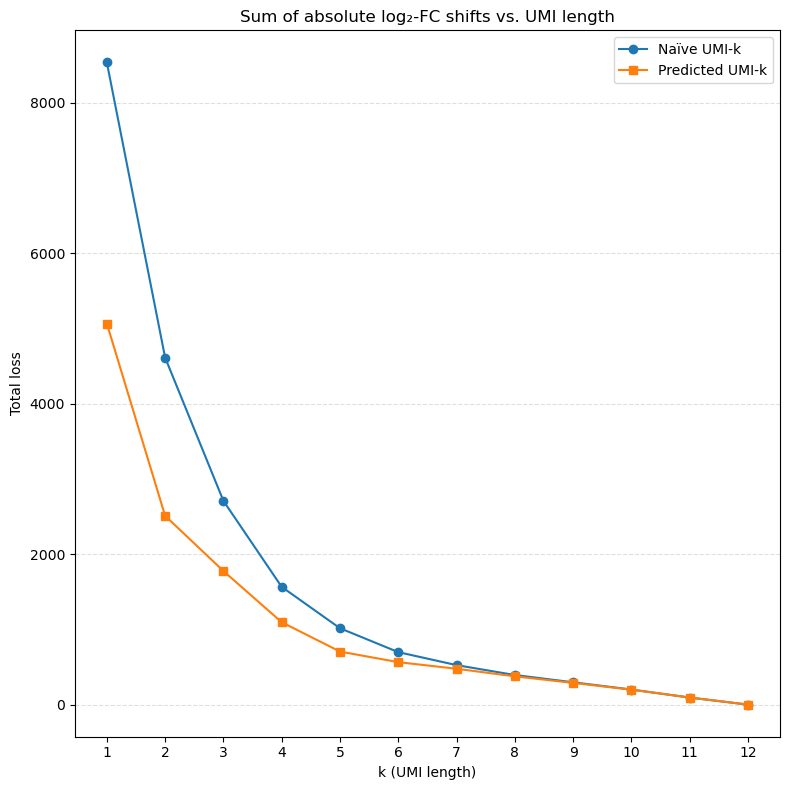

In [249]:
# 1) Define your UMI lengths and the corresponding losses:
k          = np.arange(1, 13)  # UMI lengths 1 through 12
loss_naive = np.array([8533.773, 4612.086, 2707.984, 1564.837,
                       1014.994,  697.491,  524.813,  393.293,
                        296.817,  200.129,   93.933,    0.000])
loss_pred  = np.array([5064.285, 2508.944, 1775.555, 1094.900,
                        704.999,  564.416,  476.244,  375.776,
                        288.464,  198.838,   93.594,    0.412])

# 2) Plot both curves on the same axes:
plt.figure(figsize=(8, 8))
plt.plot(k, loss_naive, marker='o', label='Naïve UMI-k')
plt.plot(k, loss_pred,  marker='s', label='Predicted UMI-k')

# 3) Formatting
plt.xticks(k)
plt.xlabel('k (UMI length)')
plt.ylabel('Total loss')
plt.title('Sum of absolute log₂-FC shifts vs. UMI length')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

# 4) Show
plt.show()


### P-value stuff

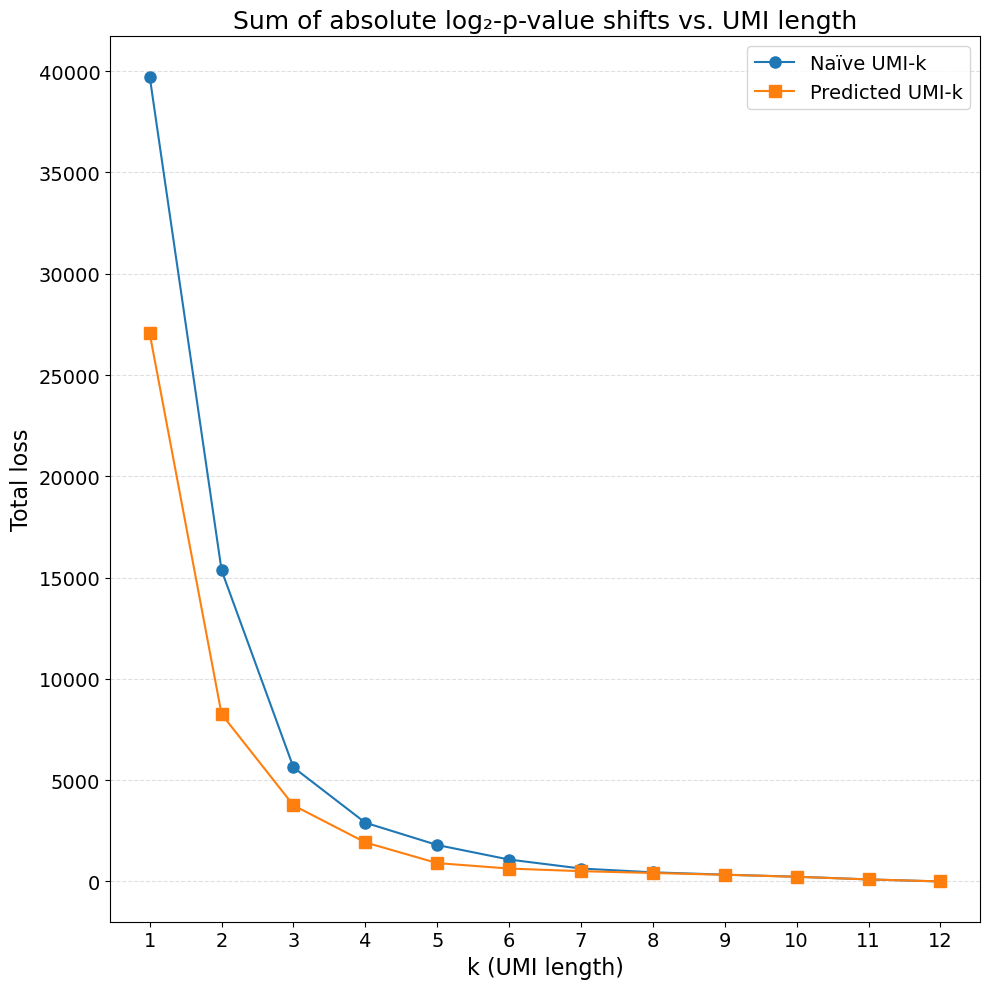

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# UMI lengths 1 through 12
k = np.arange(1, 13)

# Sum of absolute log-ratio of adjusted p-values for each UMI length
loss_p_naive = np.array([
    39733.1574, 15358.9408, 5630.5731, 2900.3900,
    1799.8847, 1082.1492,  639.5957,  450.5815,
     336.9235,  235.0299,  102.2263,    0.0000
])
loss_p_pred = np.array([
    27052.9544, 8259.1691, 3756.7196, 1928.3553,
     907.0348,  637.7139,  508.8529,  419.1341,
     330.8070,  231.1720,  101.2661,    3.6278
])

plt.figure(figsize=(10, 10))
plt.plot(k, loss_p_naive, marker='o', markersize=8, label='Naïve UMI-k')
plt.plot(k, loss_p_pred,  marker='s', markersize=8, label='Predicted UMI-k')

plt.xticks(k, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (UMI length)', fontsize=16)
plt.ylabel('Total loss', fontsize=16)
plt.title('Sum of absolute log₂-p-value shifts vs. UMI length', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/cumulative_plot.pdf")
plt.show()



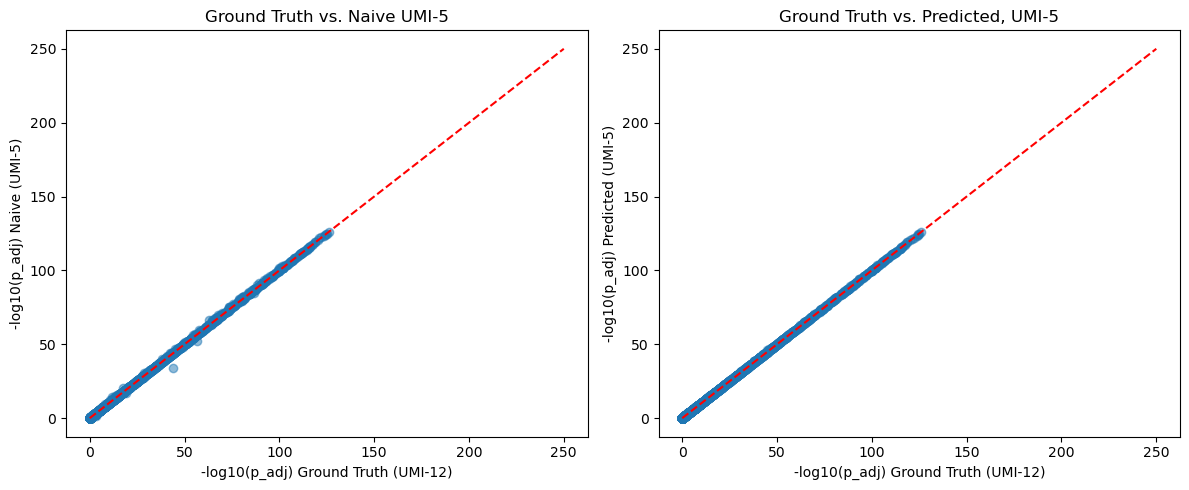

In [252]:
# === Step 3: Merge p-values by gene name for plotting ===
merged = de_12[['names', 'pvals_adj']].merge(
    de_naive[['names', 'pvals_adj']], on='names', suffixes=('_12', '_5')
).merge(
    de_pred[['names', 'pvals_adj']], on='names'
).rename(columns={'pvals_adj': 'pvals_adj_pred'})

# === Step 4: Plotting ===
plt.figure(figsize=(12, 5))

# Ground truth vs. naive
plt.subplot(1, 2, 1)
plt.scatter(-np.log10(merged['pvals_adj_12'] + 1e-300), -np.log10(merged['pvals_adj_5'] + 1e-300), alpha=0.5)
plt.plot([0, 250], [0, 250], color='red', linestyle='--', label='y=x')
plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
plt.ylabel('-log10(p_adj) Naive (UMI-5)')
plt.title(f'Ground Truth vs. Naive UMI-{j}')
# Ground truth vs. predicted
plt.subplot(1, 2, 2)
plt.scatter(-np.log10(merged['pvals_adj_12'] + 1e-300), -np.log10(merged['pvals_adj_pred'] + 1e-300), alpha=0.5)
plt.plot([0, 250], [0, 250], color='red', linestyle='--', label='y=x')
plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
plt.ylabel('-log10(p_adj) Predicted (UMI-5)')
## I want to plot the y = x line 

plt.title(f'Ground Truth vs. Predicted, UMI-{j}')

plt.tight_layout()
plt.show()

## Miscellaneus stuff

In [342]:
# import numpy as np

# #### These are genes that have an average of 10 in both groups
# keep_genes = np.loadtxt("/data/dagyeman/cellranger/kept_genes.txt", dtype=str)

# # 2. Assume de_12, de_naive, de_pred already populated
# for df, label in [
#     (de_12,    "adata_12"),
#     (de_naive, "adata_naive"),
#     (de_pred,  "adata_pred"),
# ]:
#     # Filter to only rows whose gene name is in keep_genes
#     filtered = df[df['names'].isin(keep_genes)].copy()
#     print(f"{label} — {len(filtered)} DE results for kept genes")
#     print(filtered, "\n")


adata_12 — 101 DE results for kept genes
        names     scores  logfoldchanges          pvals      pvals_adj
91        FTL  20.305302        2.340082   1.154351e-91   2.506362e-89
93       FTH1  20.207586        2.136831   8.395498e-91   1.781739e-88
104    MT-ND2  20.052610        1.202816   1.915258e-89   3.652707e-87
248    MT-ND1  16.192785        0.835022   5.670355e-59   4.397018e-57
324      ACTB  15.104406        0.731012   1.514642e-51   9.194038e-50
...       ...        ...             ...            ...            ...
28218    RPS3 -23.135828       -1.852043  2.019248e-118  2.590695e-115
28219  MALAT1 -23.159998       -1.429567  1.152837e-118  1.627000e-115
28223   RPS29 -23.574419       -2.133686  7.053973e-123  1.991054e-119
28224   RPS19 -23.580311       -2.037559  6.137741e-123  1.924932e-119
28225   RPS27 -23.811951       -2.191149  2.511596e-125  1.012747e-121

[101 rows x 5 columns] 

adata_naive — 101 DE results for kept genes
        names     scores  logfoldchan

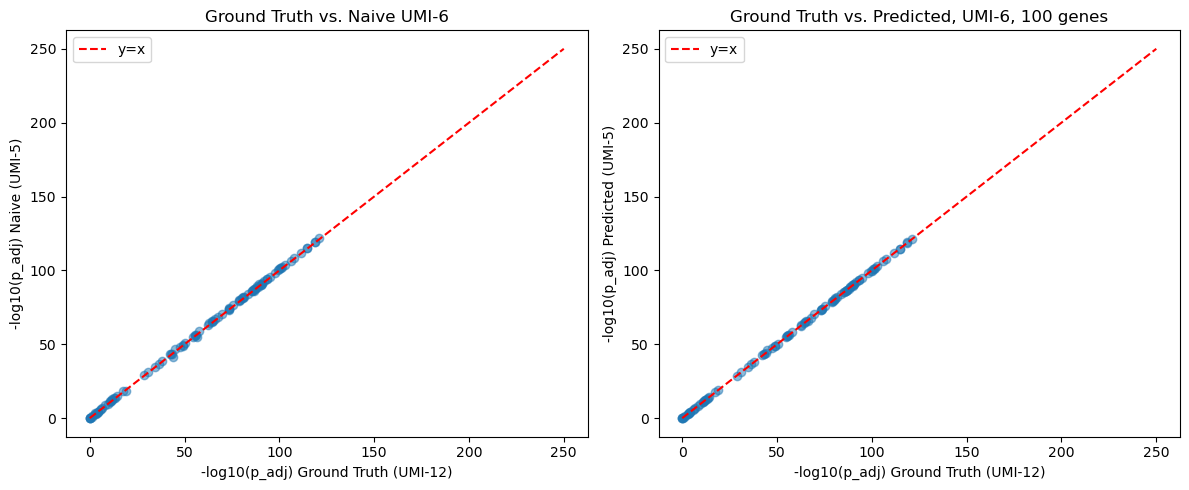

In [343]:
# # === Step 3: Merge p-values by gene name for plotting (kept genes only) ===
# merged = (
#     de_12[de_12['names'].isin(keep_genes)][['names', 'pvals_adj']]
#     .merge(
#         de_naive[de_naive['names'].isin(keep_genes)][['names', 'pvals_adj']],
#         on='names',
#         suffixes=('_12', '_5')
#     )
#     .merge(
#         de_pred[de_pred['names'].isin(keep_genes)][['names', 'pvals_adj']],
#         on='names'
#     )
#     .rename(columns={'pvals_adj': 'pvals_adj_pred'})
# )

# # === Step 4: Plotting ===
# plt.figure(figsize=(12, 5))

# # Ground truth vs. naive
# plt.subplot(1, 2, 1)
# plt.scatter(
#     -np.log10(merged['pvals_adj_12'] + 1e-300),
#     -np.log10(merged['pvals_adj_5']  + 1e-300),
#     alpha=0.5
# )
# plt.plot([0, 250], [0, 250], 'r--', label='y=x')
# plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
# plt.ylabel('-log10(p_adj) Naive (UMI-5)')
# plt.title(f'Ground Truth vs. Naive UMI-{j}')
# plt.legend()

# # Ground truth vs. predicted
# plt.subplot(1, 2, 2)
# plt.scatter(
#     -np.log10(merged['pvals_adj_12']      + 1e-300),
#     -np.log10(merged['pvals_adj_pred']    + 1e-300),
#     alpha=0.5
# )
# plt.plot([0, 250], [0, 250], 'r--', label='y=x')
# plt.xlabel('-log10(p_adj) Ground Truth (UMI-12)')
# plt.ylabel('-log10(p_adj) Predicted (UMI-5)')
# plt.title(f'Ground Truth vs. Predicted, UMI-{j}, 100 genes')
# plt.legend()

# plt.tight_layout()
# plt.show()


### Step 5: Histogram to verify results 

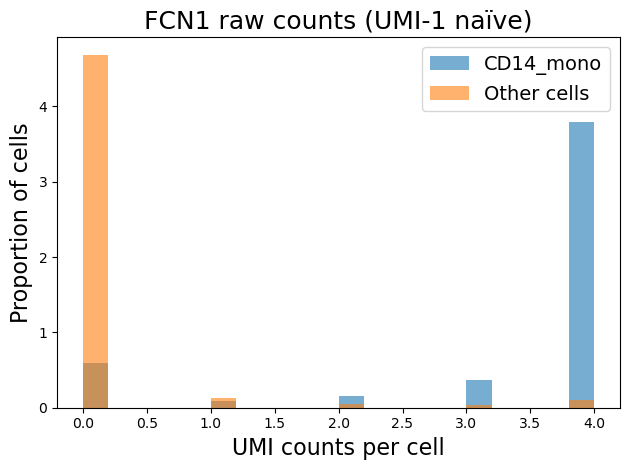

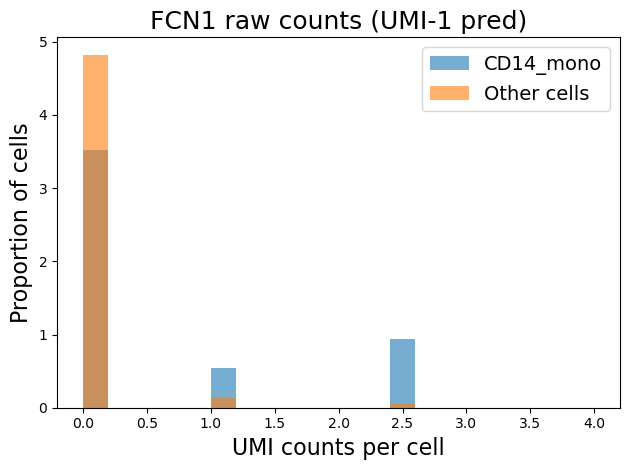

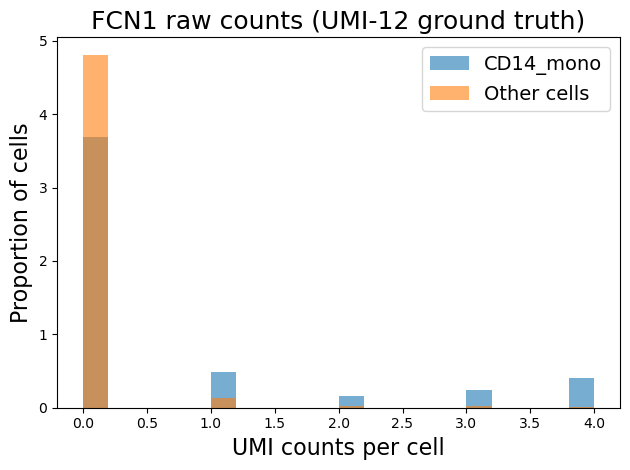

In [27]:
import matplotlib.pyplot as plt
import numpy as np

gene = "FCN1"
g_idx = adata_naive.var_names.get_loc(gene)
is_cd14 = adata_naive.obs["label"] == "CD14_mono"

# Shared raw-count bins
raw_truth = adata_naive.raw.X[:, g_idx].ravel()
nbins = 20
bins_raw = np.linspace(raw_truth.min(), raw_truth.max(), nbins + 1)

# Extract all vectors
raw_naive = adata_naive.raw.X[:, g_idx].ravel()
log_naive = adata_naive.X[:, g_idx].ravel()
raw_pred  = adata_pred.raw.X[:, g_idx].ravel()
log_pred  = adata_pred.X[:, g_idx].ravel()
raw_truth = adata_12.raw.X[:, g_idx].ravel()
log_truth = adata_12.X[:, g_idx].ravel()

# 1) Naïve raw
plt.figure()
plt.hist(raw_naive[is_cd14], bins=bins_raw, density=True, alpha=0.6, label="CD14_mono")
plt.hist(raw_naive[~is_cd14], bins=bins_raw, density=True, alpha=0.6, label="Other cells")
plt.title(f"{gene} raw counts (UMI-{j} naïve)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Proportion of cells", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# # 2) Naïve log
# plt.figure()
# plt.hist(log_naive[is_cd14], bins=20, density=True, alpha=0.6, label="CD14_mono")
# plt.hist(log_naive[~is_cd14], bins=20, density=True, alpha=0.6, label="Other cells")
# plt.title(f"{gene} logₑ(1 + CP10k) (UMI-{j} naïve)", fontsize=18)
# plt.xlabel("logₑ(1 + CP10k)", fontsize=16)
# plt.ylabel("Proportion of cells", fontsize=16)
# plt.legend(fontsize=14)
# plt.tight_layout()
# plt.show()

# 3) Predicted raw
plt.figure()
plt.hist(raw_pred[is_cd14], bins=bins_raw, density=True, alpha=0.6, label="CD14_mono")
plt.hist(raw_pred[~is_cd14], bins=bins_raw, density=True, alpha=0.6, label="Other cells")
plt.title(f"{gene} raw counts (UMI-{j} pred)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Proportion of cells", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# # 4) Predicted log
# plt.figure()
# plt.hist(log_pred[is_cd14], bins=20, density=True, alpha=0.6, label="CD14_mono")
# plt.hist(log_pred[~is_cd14], bins=20, density=True, alpha=0.6, label="Other cells")
# plt.title(f"{gene} logₑ(1 + CP10k) (UMI-{j} pred)", fontsize=18)
# plt.xlabel("logₑ(1 + CP10k)", fontsize=16)
# plt.ylabel("Proportion of cells", fontsize=16)
# plt.legend(fontsize=14)
# plt.tight_layout()
# plt.show()

# 5) Truth raw
plt.figure()
plt.hist(raw_truth[is_cd14], bins=bins_raw, density=True, alpha=0.6, label="CD14_mono")
plt.hist(raw_truth[~is_cd14], bins=bins_raw, density=True, alpha=0.6, label="Other cells")
plt.title(f"{gene} raw counts (UMI-12 ground truth)", fontsize=18)
plt.xlabel("UMI counts per cell", fontsize=16)
plt.ylabel("Proportion of cells", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# # 6) Truth log
# plt.figure()
# plt.hist(log_truth[is_cd14], bins=20, density=True, alpha=0.6, label="CD14_mono")
# plt.hist(log_truth[~is_cd14], bins=20, density=True, alpha=0.6, label="Other cells")
# plt.title(f"{gene} logₑ(1 + CP10k) (UMI-12 ground truth)", fontsize=18)
# plt.xlabel("logₑ(1 + CP10k)", fontsize=16)
# plt.ylabel("Proportion of cells", fontsize=16)
# plt.legend(fontsize=14)
# plt.tight_layout()
# plt.show()





### How the log fold change is calculated

In [180]:
# import numpy as np

# genes = ["S100A8","FCN1","VCAN","CSF3R","S100A9"]
# eps = 1e-9

# mask1 = adata_12.obs['label']=="CD14_mono"
# mask2 = adata_12.obs['label']=="Other cells"

# for g in genes:
#     idx = adata_12.var_names.get_loc(g)
#     ### pull the log1p-CP10k values from .X
#     x = adata_12.X[:, idx].toarray().ravel() if hasattr(adata_12.X, "toarray") else adata_12.X[:, idx]
    
#     # means on the log-scale
#     mu1 = x[mask1].mean()
#     mu2 = x[mask2].mean()
    
#     # invert log1p to get back to normalized counts
#     m1 = np.expm1(mu1)
#     m2 = np.expm1(mu2)
    
#     l2fc = np.log2((m1 + eps) / (m2 + eps))
    
#     print(f"{g}: log_CD14_mean = {mu1:.4f}, log_Other_cells_mean = {mu2:.4f}  =>  CD14_mean1 = {m1:.3f}, Other_cells_mean2 = {m2:.3f}   =>  log₂FC = {l2fc:.3f}")


S100A8: log_CD14_mean = 3.7810, log_Other_cells_mean = 0.1427  =>  CD14_mean1 = 42.862, Other_cells_mean2 = 0.153   =>  log₂FC = 8.126
FCN1: log_CD14_mean = 2.3171, log_Other_cells_mean = 0.0870  =>  CD14_mean1 = 9.146, Other_cells_mean2 = 0.091   =>  log₂FC = 6.652
VCAN: log_CD14_mean = 2.6226, log_Other_cells_mean = 0.0832  =>  CD14_mean1 = 12.772, Other_cells_mean2 = 0.087   =>  log₂FC = 7.201
CSF3R: log_CD14_mean = 1.5613, log_Other_cells_mean = 0.0485  =>  CD14_mean1 = 3.765, Other_cells_mean2 = 0.050   =>  log₂FC = 6.242
S100A9: log_CD14_mean = 4.0534, log_Other_cells_mean = 0.2062  =>  CD14_mean1 = 56.593, Other_cells_mean2 = 0.229   =>  log₂FC = 7.949


### Genes with at least average 10 across all cells

In [167]:
import numpy as np


keep_genes = np.loadtxt("/data/dagyeman/cellranger/kept_genes.txt", dtype=str)

adata_12    = adata_12[:, keep_genes].copy()
adata_naive = adata_naive[:, keep_genes].copy()
adata_pred  = adata_pred[:, keep_genes].copy()

sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)


sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

sc.pp.normalize_total(adata_pred, target_sum=1e4)
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)

print(np.linalg.norm(adata_12.X - adata_naive.X, ord='fro'))
print(np.linalg.norm(adata_12.X - adata_pred.X,  ord='fro'))
print(np.linalg.norm(adata_naive.X - adata_pred.X, ord='fro'))


This is the matrix for adata_12 [[5.01418991 4.32715097 5.04481091 ... 5.00492528 4.86495733 4.4735181 ]
 [4.59208928 4.04190053 4.67239779 ... 4.49210666 4.73151878 4.44758472]
 [4.9733977  4.5929286  5.03848435 ... 4.94229194 4.63329403 4.40725831]
 ...
 [4.39140194 4.02810588 4.77611963 ... 4.56304937 4.78916574 4.20068   ]
 [4.85202606 4.55129895 4.92006664 ... 4.85602139 4.90194182 4.52046492]
 [4.52832262 3.69247869 4.6534209  ... 4.62791493 4.76413333 4.42843153]]
This is the matrix for adata_naive [[4.63609082 4.50289831 4.63609082 ... 4.63609082 4.63609082 4.63609082]
 [4.6211292  4.49750523 4.6211292  ... 4.6211292  4.6211292  4.6211292 ]
 [4.66077579 4.66077579 4.66077579 ... 4.66077579 4.66077579 4.54683917]
 ...
 [4.3528319  4.6470383  4.6470383  ... 4.6470383  4.6470383  4.3528319 ]
 [4.60906641 4.60906641 4.60906641 ... 4.60906641 4.60906641 4.60906641]
 [4.62619459 4.33413954 4.62619459 ... 4.51208299 4.62619459 4.62619459]]
This is the matrix for adata_pred [[4.6544537

In [182]:
keep_genes = np.loadtxt("/data/dagyeman/cellranger/kept_genes.txt", dtype=str)
print(keep_genes)

['ACTB' 'ACTG1' 'B2M' 'CD74' 'EEF1A1' 'EIF1' 'FAU' 'FOXP1' 'FTH1' 'FTL'
 'H3F3B' 'HLA-A' 'HLA-B' 'HLA-C' 'HLA-DRA' 'JUN' 'MALAT1' 'MBNL1'
 'MT-ATP6' 'MT-CO1' 'MT-CO2' 'MT-CO3' 'MT-CYB' 'MT-ND1' 'MT-ND2' 'MT-ND3'
 'MT-ND4' 'MT-ND5' 'NACA' 'PTMA' 'PTPRC' 'RACK1' 'RPL10' 'RPL10A' 'RPL11'
 'RPL12' 'RPL13' 'RPL13A' 'RPL14' 'RPL15' 'RPL17' 'RPL18' 'RPL18A' 'RPL19'
 'RPL21' 'RPL22' 'RPL23A' 'RPL24' 'RPL26' 'RPL27' 'RPL28' 'RPL29' 'RPL3'
 'RPL30' 'RPL32' 'RPL34' 'RPL35A' 'RPL36' 'RPL36A' 'RPL37' 'RPL37A'
 'RPL39' 'RPL4' 'RPL41' 'RPL5' 'RPL6' 'RPL7A' 'RPL8' 'RPL9' 'RPLP1'
 'RPLP2' 'RPS10;RPS10-NUDT3' 'RPS11' 'RPS12' 'RPS13' 'RPS14' 'RPS15'
 'RPS15A' 'RPS16' 'RPS18' 'RPS19' 'RPS2' 'RPS21' 'RPS23' 'RPS24' 'RPS25'
 'RPS27' 'RPS27A' 'RPS28' 'RPS29' 'RPS3' 'RPS3A' 'RPS4X' 'RPS6' 'RPS7'
 'RPS8' 'RPS9' 'TMSB10' 'TMSB4X' 'TPT1' 'UBA52']


### PLotting 

In [363]:
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth

import pandas as pd
import numpy as np
import scipy.sparse as sp

X = adata_12.X
avg_counts = (np.asarray(X.mean(axis=0)).ravel()
              if sp.issparse(X) else X.mean(axis=0))

df_avg = pd.DataFrame({
    "gene": adata_12.var_names,
    "avg_count": avg_counts
})

max(df_avg['avg_count'])  # Maximum average count across all genes

286.14285714285717

 ## MOST UP TO DATE PIPELINE 